# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


Стадии обогащения руды:<br>
**1. Флотация** <br>
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов. На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).<br>
**2. Очистка** <br>
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Технологический процесс**<br>
* Rougher feed — исходное сырье 
* Rougher additions (или reagent additions) — флотационные 
реагенты: Xanthate, Sulphate, Depressant 
 - Xanthate **— ксантогенат (промотер, или активатор флотации); 
 - Sulphate — сульфат (на данном производстве сульфид натрия); 
 - Depressant — депрессант (силикат натрия). 
* Rougher process (англ. «грубый процесс») — флотация 
* Rougher tails — отвальные хвосты 
* Float banks — флотационная установка 
* Cleaner process — очистка 
* Rougher Au — черновой концентрат золота 
* Final Au — финальный концентрат золота 

**Параметры этапов**<br>
* air amount — объём воздуха 
* fluid levels — уровень жидкости 
* feed size — размер гранул сырья 
* feed rate — скорость подачи

**Наименование признаков**<br>
Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра] <br>
Пример: rougher.input.feed_ag <br>

Возможные значения для блока [этап]: 
* rougher — флотация 
* primary_cleaner — первичная очистка 
* secondary_cleaner — вторичная очистка 
* final — финальные характеристики 

Возможные значения для блока [тип_параметра]: 
* input — параметры сырья 
* output — параметры продукта 
* state — параметры, характеризующие текущее состояние этапа 
* calculation — расчётные характеристики 

**Расчёт эффективности:**<br>
Необходимо смоделировать процесс восстановления золота из золотосодержащей руды.
*Эффективность обогащения рассчитывается по формуле:*

$$Recovery = \frac{C \times (F - T)}{F \times (C - T)} \times 100\%$$

*Где:*<br>
    - C — доля золота в концентрате после флотации/очистки;
    - F — доля золота в сырье/концентрате до флотации/очистки;
    - T — доля золота в отвальных хвостах после флотации/очистки.
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.<br>
**Метрика качества:**<br>
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).<br>
*Формула:*<br>

$$\mathit{sMAPE} = \frac{1}{N} \sum\limits _{i = 1} ^{N} \frac{\left| y_i - \hat{y}_i \right|}{\left( \left| y_i \right| + \left|\hat{y}_i \right| \right) / 2} \times 100\%$$

*Где:*<br>
- $y_i$ - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
- $\hat{y}_i$ - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
- N - Количество объектов в выборке.
- $\sum\limits _{i = 1} ^{N}$ - Суммирование по всем объектам выборки (i меняется от 1 до N).

Нужно спрогнозировать сразу две величины:<br>
    - эффективность обогащения чернового концентрата rougher.output.recovery;
    - эффективность обогащения финального концентрата final.output.recovery.
Итоговая метрика складывается из двух величин:<br><br>
$$\mathit{resulting\ sMAPE} = 25\% \times \mathit{sMAPE}_{ROUGHER} + 75\% \times \mathit{sMAPE}_{FINAL} $$

## Подготовка данных

In [ ]:
!pip install optuna

In [ ]:
!pip install imbalanced-learn --user

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
import optuna

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn import FunctionSampler

from pylab import rcParams
from matplotlib.gridspec import GridSpec
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    LinearRegression, LogisticRegression, HuberRegressor, PassiveAggressiveRegressor,
    ARDRegression, BayesianRidge, SGDRegressor, ElasticNet
)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.impute import KNNImputer
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    BaggingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor
)

from sklearn.tree import DecisionTreeRegressor

from scipy import stats as st
from numpy.random import RandomState

In [2]:
rcParams['figure.figsize'] = (12, 8)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

RANDOM_STATE = 12345

<Figure size 864x576 with 0 Axes>

In [3]:
# сделаем треугольную матрицу heatmap без диагональных элементов
def corr_triag_heatmap(corr, title_str):
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    if show_corr_zero_plots:
        # готовим матрицу корреляций нулей
        t = df.isin([0,'0']).sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isin([0,'0']).sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()
    if show_corr_null_plots:
        # готовим матрицу корреляций нулей
        t = df.isna().sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isna().corr()
            corr_triag_heatmap(corr, "Correlation of NULL in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isna().sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of NULL values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

    # статистики
    display(df.describe(include='all').transpose())
    
    if show_scatter_matrix:
        pd.plotting.scatter_matrix(df, figsize=(16,10), alpha=0.1, s=5);


In [4]:
try:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', sep=',')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', sep=',')
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', sep=',')
except:
    df_train = pd.read_csv('datasets\yandex_09_gold_recovery_train_new.csv', sep=',')
    df_test = pd.read_csv('datasets\yandex_09_gold_recovery_test_new.csv', sep=',')
    df_full = pd.read_csv('datasets\yandex_09_gold_recovery_full_new.csv', sep=',')



In [5]:
def na0(df):
    return [df.isin([0]).sum().sum(), df.isna().sum().sum(), df.shape]

In [6]:
displ=[]
for df in df_train, df_test, df_full:
    displ.append(na0(df)) 
pd.DataFrame(displ, columns=['zeros', 'NaN', 'shape'])

,zeros,NaN,shape
0,5621,4100,"(14149, 87)"
1,1,90,"(5290, 53)"
2,7171,4481,"(19439, 87)"



------SAMPLE--------


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2449,2016-05-20 00:59:59,5.968,9.973,12.273,43.107,73.768,11.033,2.956,9.370,3.489,180.088,19.966,8.900,0.547,9.541,9.545,19.677,33.546,19.419,4.989,8.679,7.601,"1,200.264",-550.311,"1,201.961",-549.780,"1,200.312",-549.435,"1,200.238",-549.595,"46,401.377","3,133.128","3,132.883",2.227,11.811,4.864,401.191,49.711,34.877,10.833,14.001,5.287,13.969,5.280,15.544,8.147,34.572,21.934,87.348,7.058,0.565,14.999,2.411,896.044,-500.324,998.751,-500.242,"1,000.920",-499.802,949.627,-500.505,901.067,-500.874,764.893,-500.183,19.735,5.149,13.141,5.679,25.936,-458.294,24.007,-499.642,24.996,-500.175,21.971,-499.461,10.001,-499.839,7.984,-500.163,8.882,-549.987,6.037,-549.625,20.015,-599.667
6584,2016-12-01 01:59:59,6.122,9.281,12.687,43.989,71.930,12.381,3.422,11.546,3.488,221.665,7.002,7.100,1.402,10.482,10.683,14.383,30.818,18.439,4.248,10.089,3.140,"1,498.687",-499.529,"1,502.673",-500.544,"1,502.753",-500.080,"1,501.704",-500.563,"51,910.541","2,822.604","2,822.758",2.498,11.048,4.134,500.904,47.249,37.238,10.328,14.498,6.402,14.503,6.401,14.608,8.058,32.735,24.16


------DTYPES--------
date                                                   object
final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.input.sulfate                         float64
primary_cleaner.input.depressant                      float64
primary_cleaner.input.feed_size                       float64
primary_cleaner.input.xanthate                        float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb           

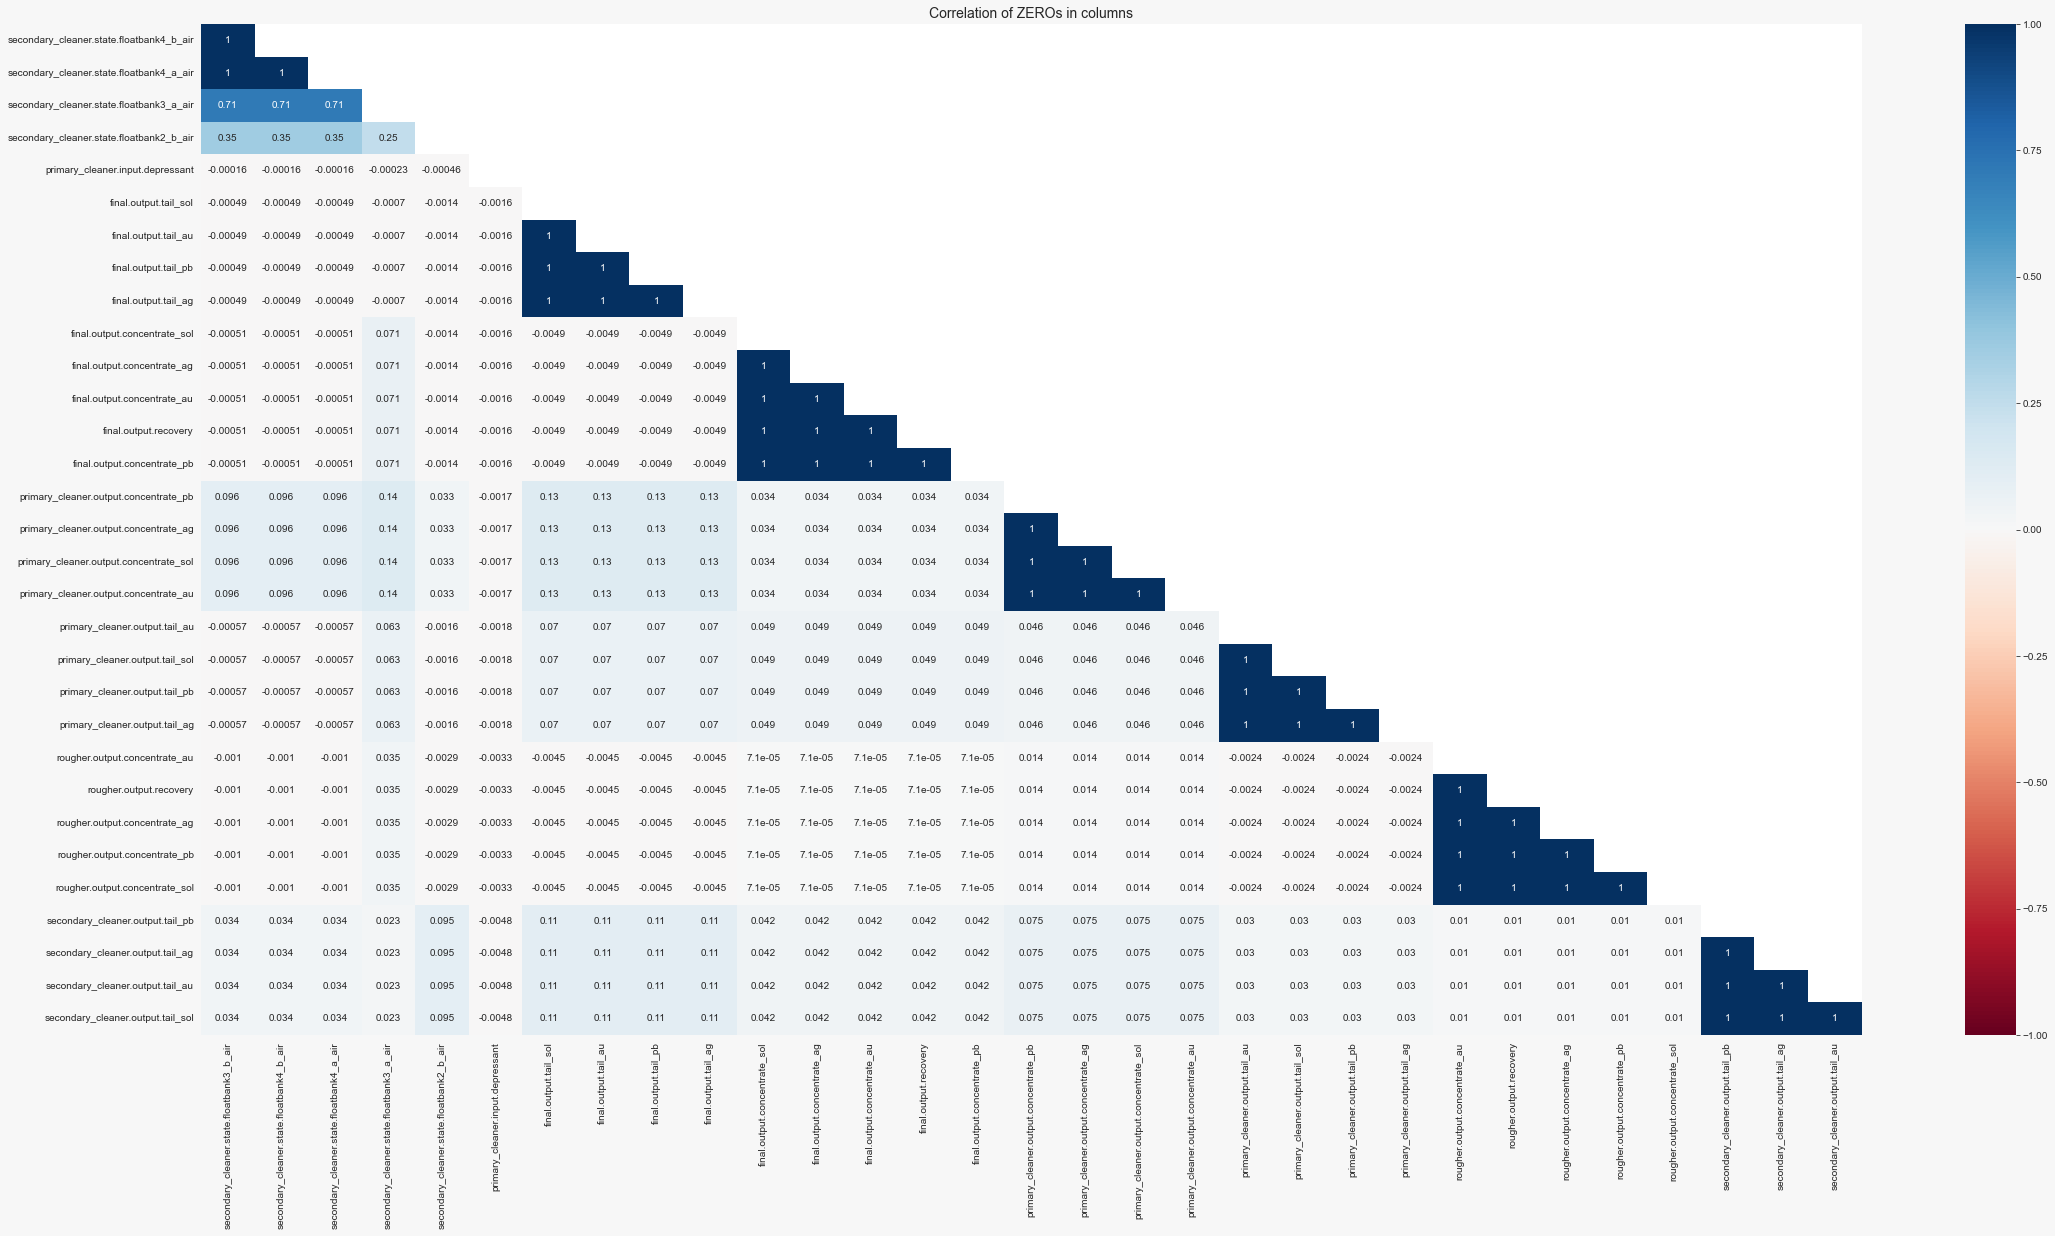

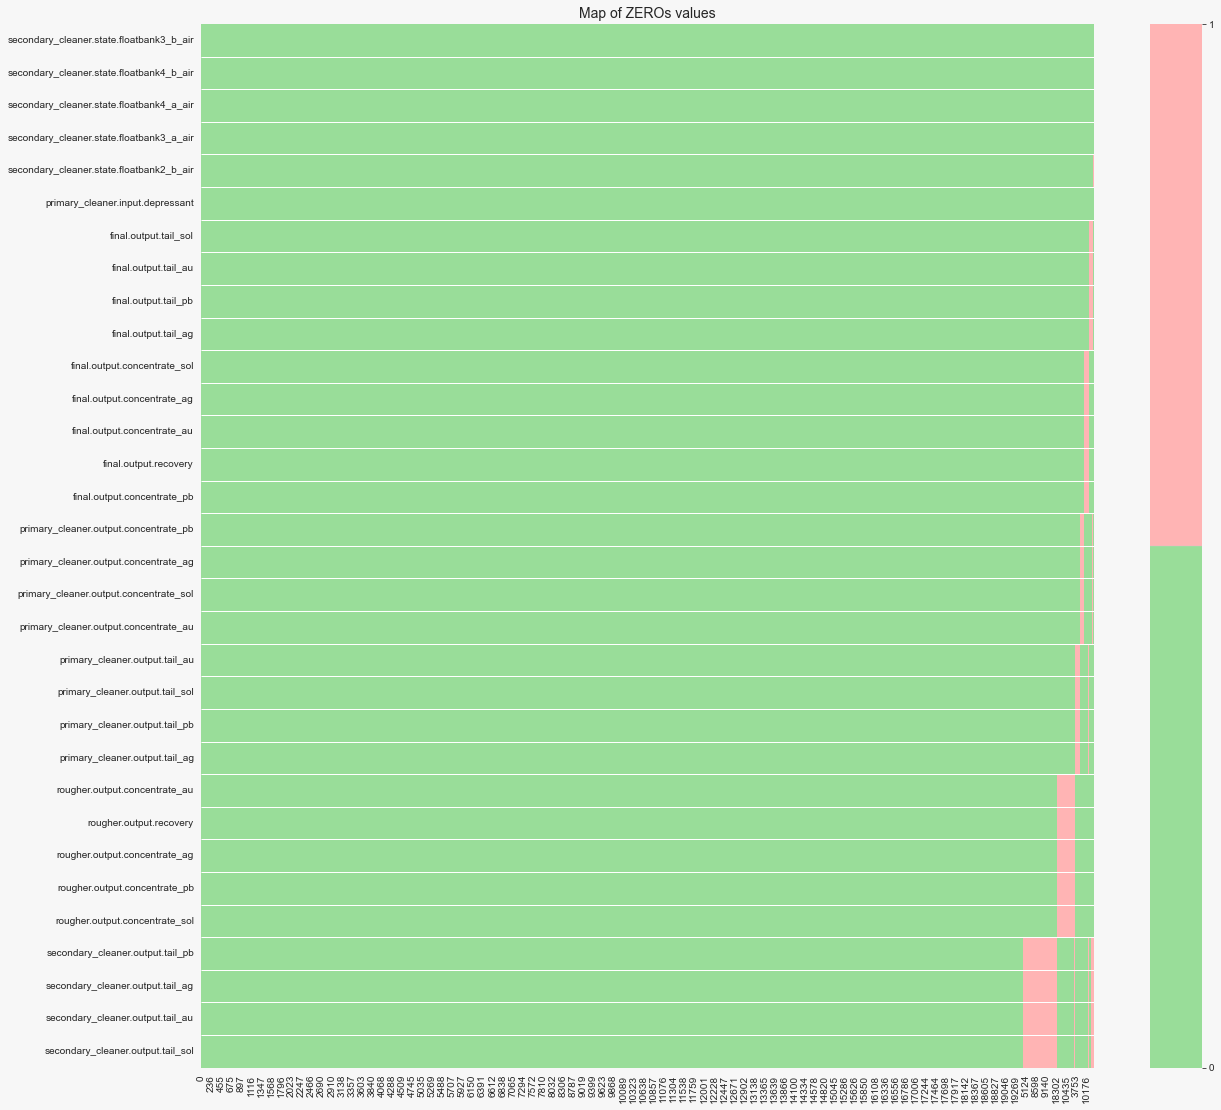

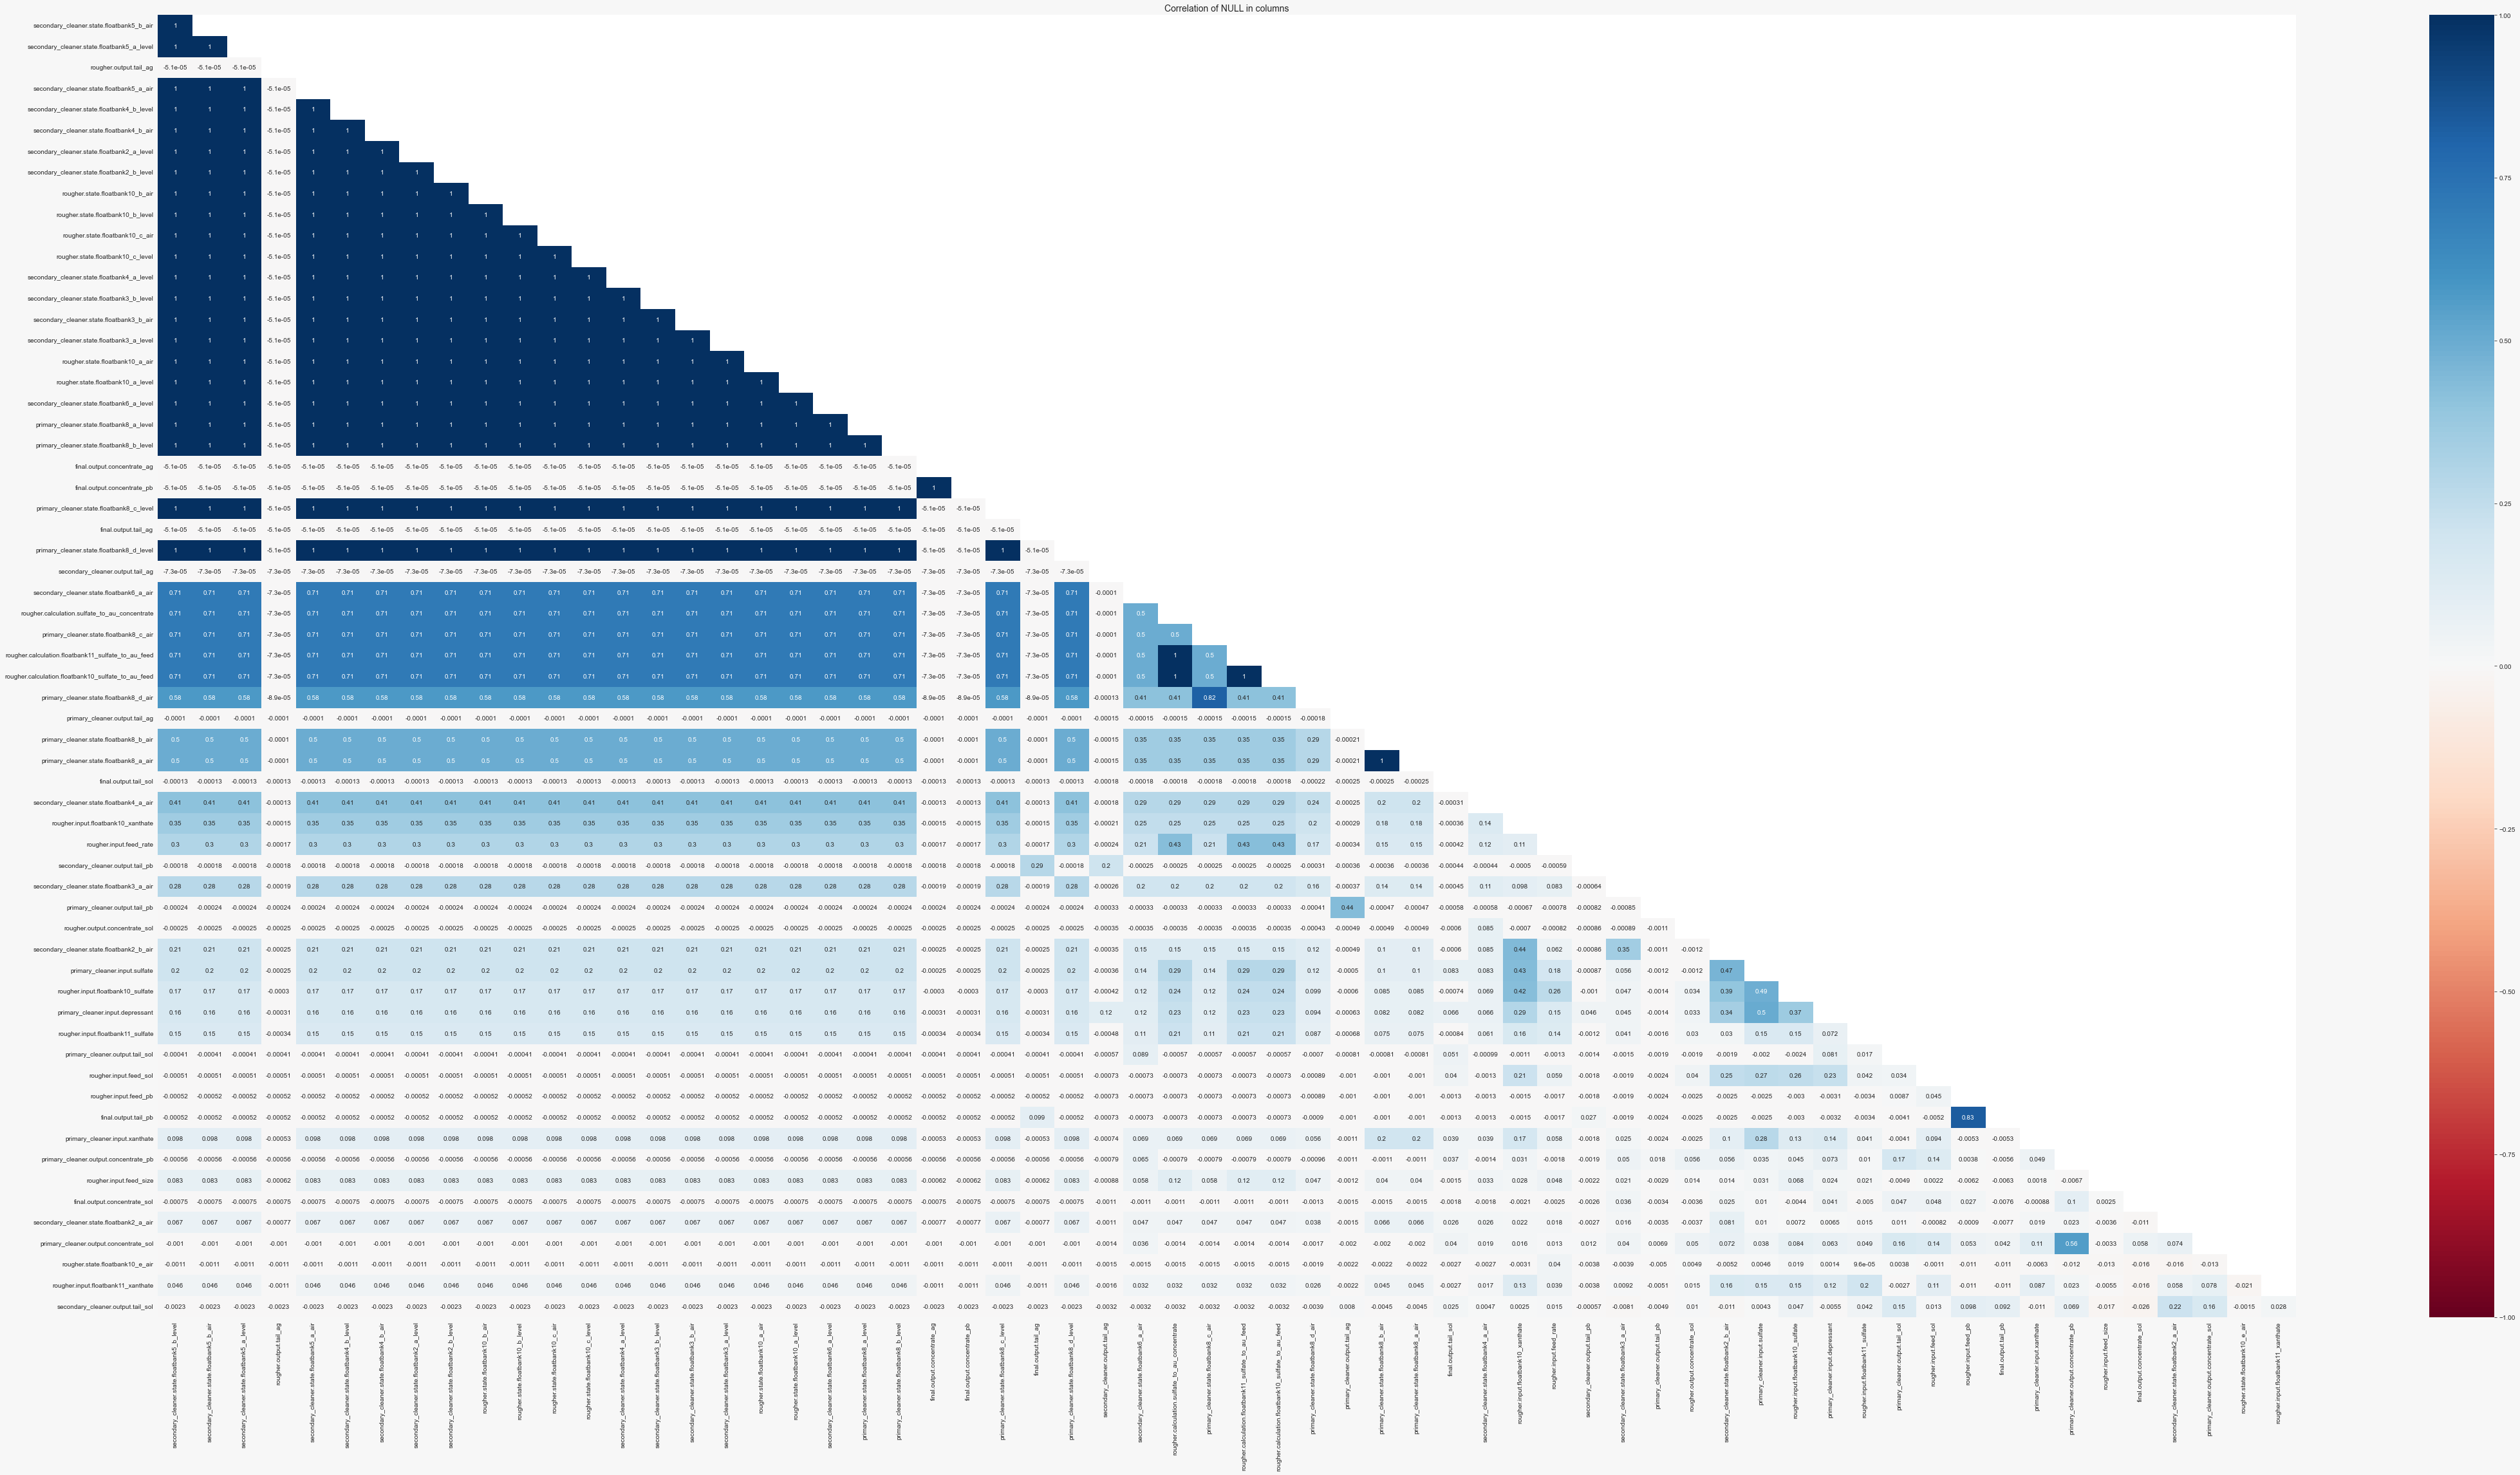

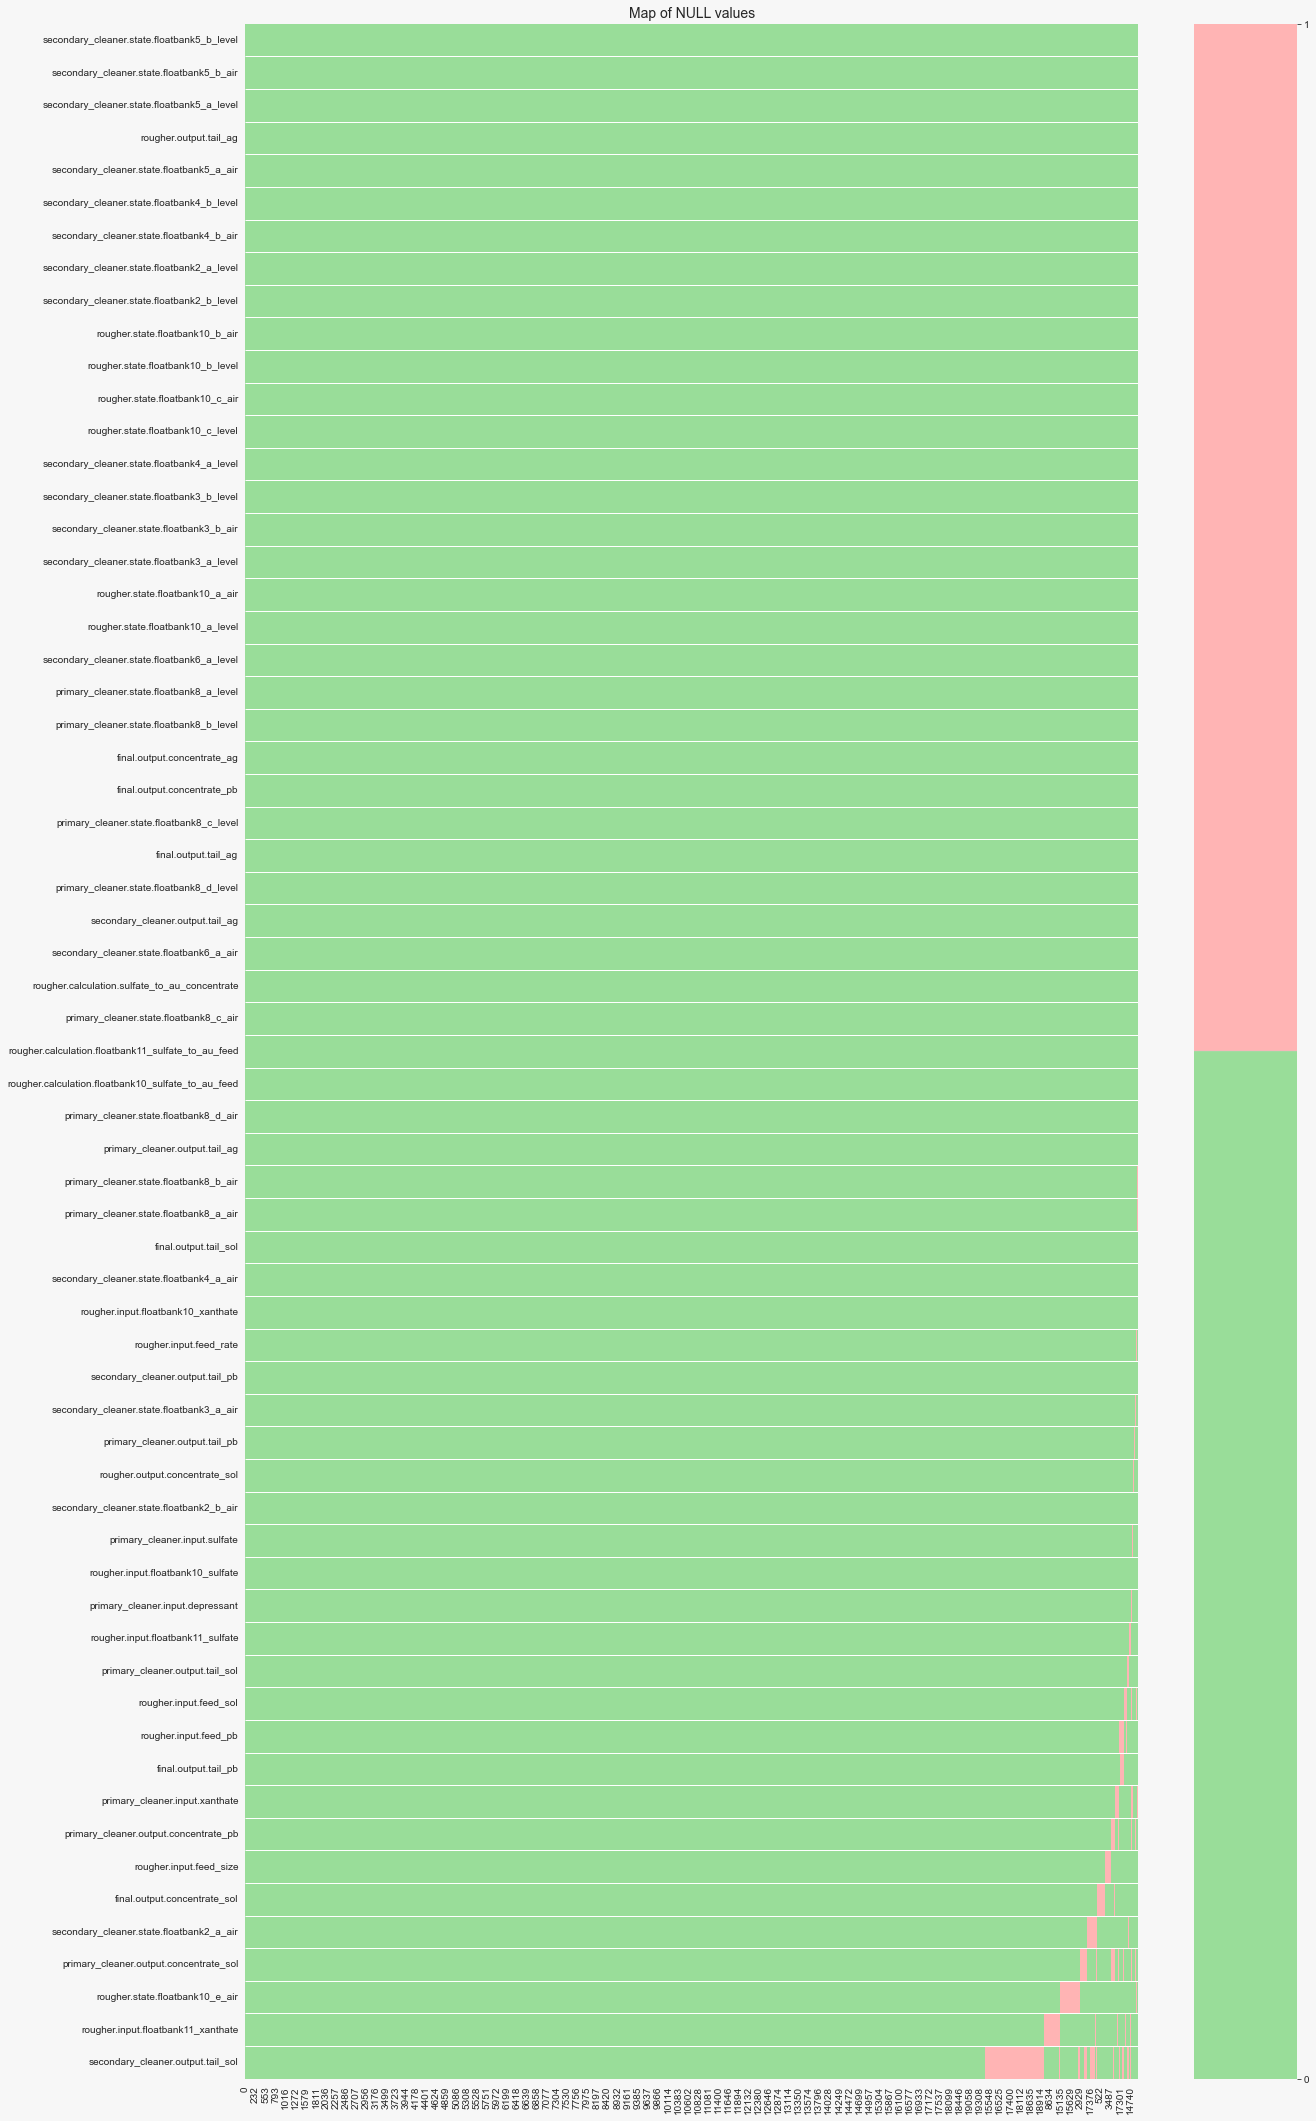

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,19439,19439,2016-01-15 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
final.output.concentrate_ag,"19,438.000",NaN,NaN,NaN,5.168,1.372,0.000,4.251,5.066,5.896,16.002
final.output.concentrate_pb,"19,438.000",NaN,NaN,NaN,9.979,1.669,0.000,9.137,10.102,11.036,17.032
final.output.concentrate_sol,"19,228.000",NaN,NaN,NaN,9.501,2.788,0.000,7.723,9.219,10.948,19.616
final.output.concentrate_au,"19,439.000",NaN,NaN,NaN,44.077,5.130,0.000,43.402,45.011,46.275,52.757
final.output.recovery,"19,439.000",NaN,NaN,NaN,67.050,10.126,0.000,63.300,68.173,72.687,100.000
final.output.tail_ag,"19,438.000",NaN,NaN,NaN,9.689,2.329,0.000,8.063,9.744,11.134,19.552
final.output.tail_pb,"19,338.000",NaN,NaN,NaN,2.706,0.949,0.000,2.040,2.749,3.333,5.804
final.output.tail_sol,"19,433.000",NaN,NaN,NaN,10.584,2.869,0.000,8.939,10.622,12.104,22.318
final.output.tail_au,"19,439.000",NaN,NaN,NaN,3.042,0.923,0.000,2.461,2.985,3.571,8.245


In [7]:
evaluate_df(df_full, True, True)

In [8]:

##  Функция для определения выбросов (по методу IQR или 3s) и их удаления
### анализируется столбец column и смотрится распределение значений и удаляются выбросы
def calc_bounds_outliers(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):
    
    t1 = df[column].describe()
    if mode == 'iqr':
        iqr = t1['75%']-t1['25%']
        l_bound = max(t1['25%'] - iqr*k_lbound, t1['min'])
        u_bound = min(t1['75%'] + iqr*k_ubound, t1['max'])
    else:
        l_bound = t1['mean'] - 3*t1['std']
        u_bound = t1['mean'] + 3*t1['std']
    
    return l_bound, u_bound

##  Функция для удаления строк с выбросами
### анализируется столбец column и смотрится распределение значений и удаляются выбросы
def delete_outliers(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):
    
    l_bound, u_bound = calc_bounds_outliers(df, column, mode, k_lbound, k_ubound)

    print('\n' + column + ' ')
    print(f'bounds are:({l_bound:.2f},{u_bound:.2f})')
    b = len(df)
    df = df.loc[(df[column] <= u_bound) & (l_bound <= df[column])]
    print(f'Удалено:{(b-len(df))} ({(b-len(df))/b:.1%})')
    
    return df

##  Функция для замены строк с выбросами на NaN
### Анализируется столбец column и смотрится распределение значений и  выбросы заменяются на NaN
def set_outliers_as_nan(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):
    l_bound, u_bound = calc_bounds_outliers(df, column, mode, k_lbound, k_ubound)
    df.loc[(df[column] >= u_bound) & (l_bound <= df[column])] = np.nan
    return df


-------  column final.output.concentrate_ag  ----------
Count NaN: 1
Count ZERO: 58
MAX: 16.001945119452092
MIN: 0.0
Границы по IQR: 0.916 ... 9.155
Границы по 3s: 1.033 ... 9.251


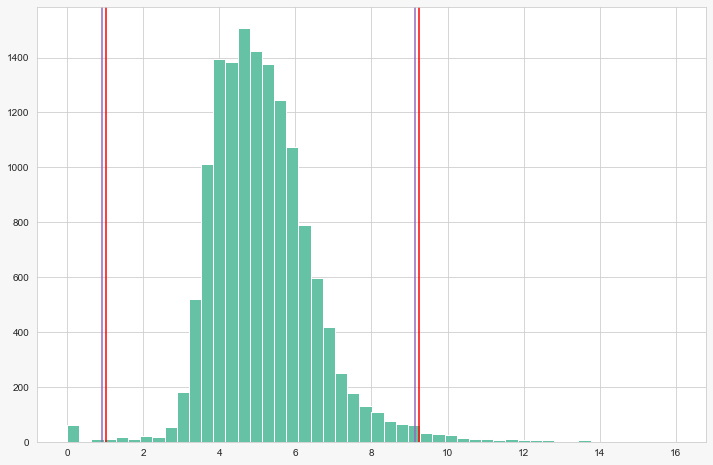

-------  column final.output.concentrate_pb  ----------
Count NaN: 1
Count ZERO: 58
MAX: 17.031899460483757
MIN: 0.0
Границы по IQR: 5.551 ... 14.917
Границы по 3s: 5.168 ... 15.098


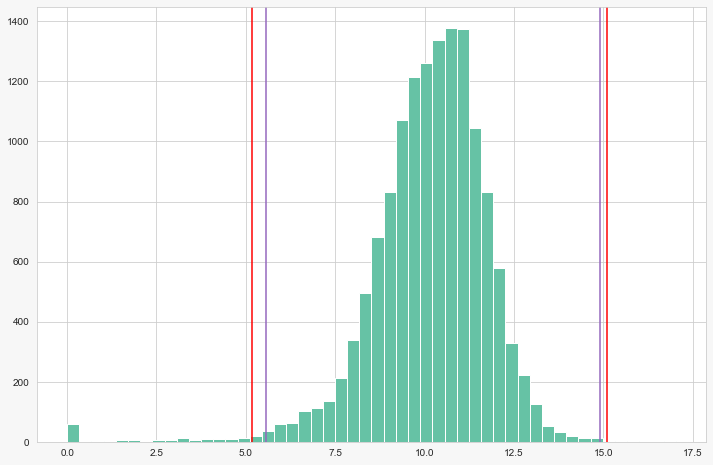

-------  column final.output.concentrate_sol  ----------
Count NaN: 211
Count ZERO: 58
MAX: 18.12485093699561
MIN: 0.0
Границы по IQR: 1.479 ... 16.493
Границы по 3s: 0.831 ... 17.574


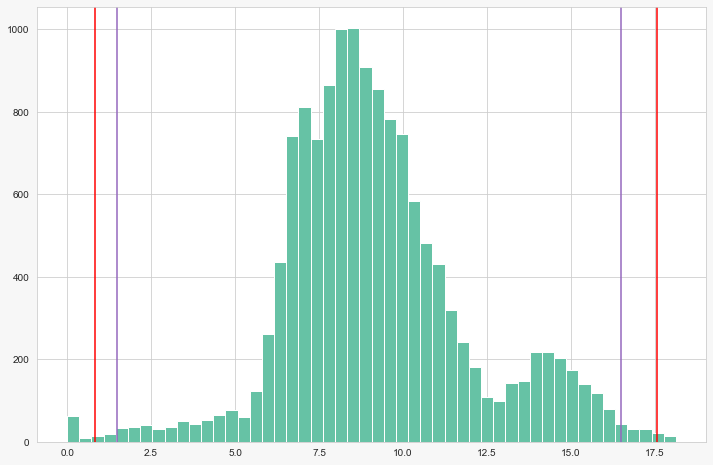

-------  column final.output.concentrate_au  ----------
Count NaN: 0
Count ZERO: 58
MAX: 52.756637616965854
MIN: 0.0
Границы по IQR: 37.495 ... 51.947
Границы по 3s: 29.288 ... 58.720


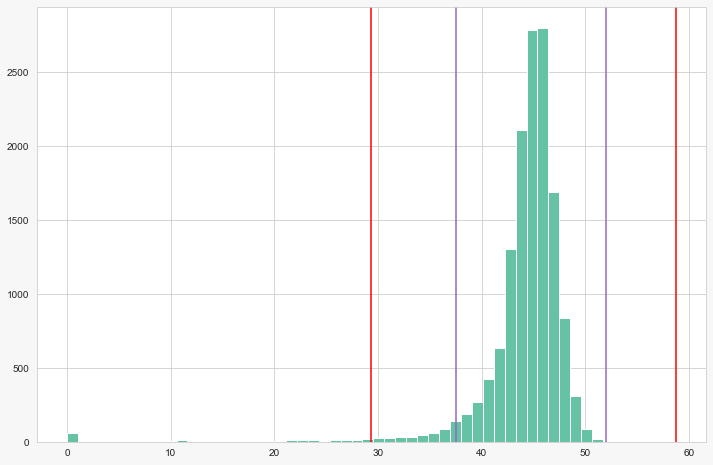

-------  column final.output.recovery  ----------
Count NaN: 0
Count ZERO: 58
MAX: 100.0
MIN: 0.0
Границы по IQR: 42.945 ... 91.948
Границы по 3s: 35.633 ... 97.405


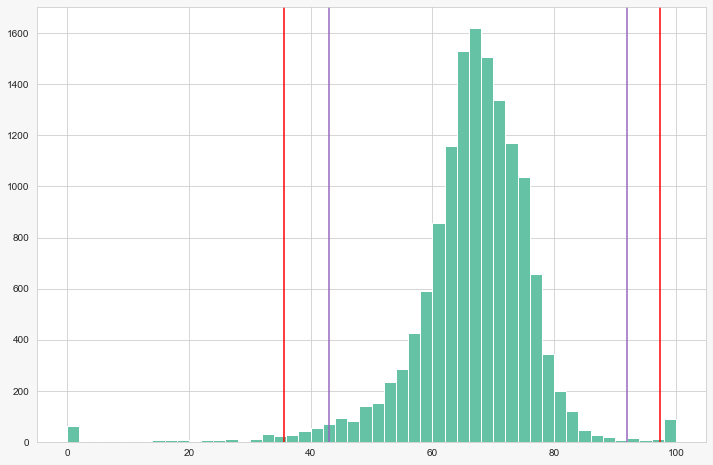

-------  column final.output.tail_ag  ----------
Count NaN: 0
Count ZERO: 75
MAX: 19.55214857336269
MIN: 0.0
Границы по IQR: 1.985 ... 17.016
Границы по 3s: 2.650 ... 16.564


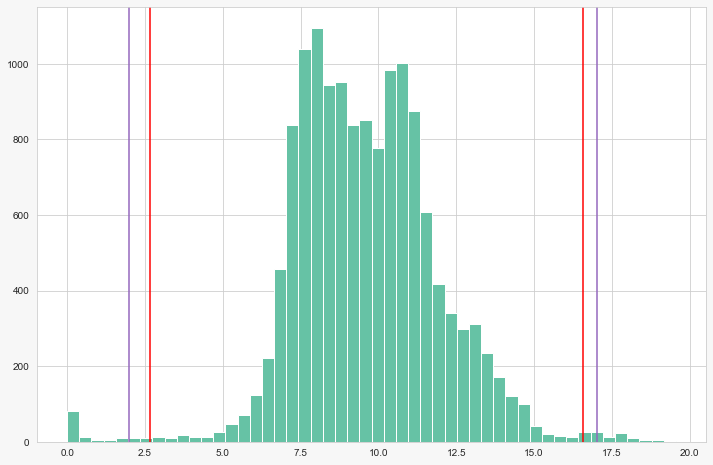

-------  column final.output.tail_pb  ----------
Count NaN: 100
Count ZERO: 75
MAX: 5.639565029011832
MIN: 0.0
Границы по IQR: 0.000 ... 5.640
Границы по 3s: -0.318 ... 5.513


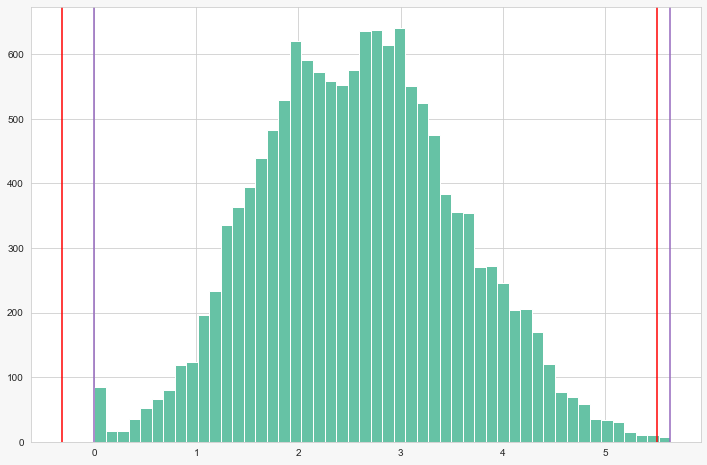

-------  column final.output.tail_sol  ----------
Count NaN: 5
Count ZERO: 75
MAX: 22.317730335129628
MIN: 0.0
Границы по IQR: 2.568 ... 18.176
Границы по 3s: 1.501 ... 19.523


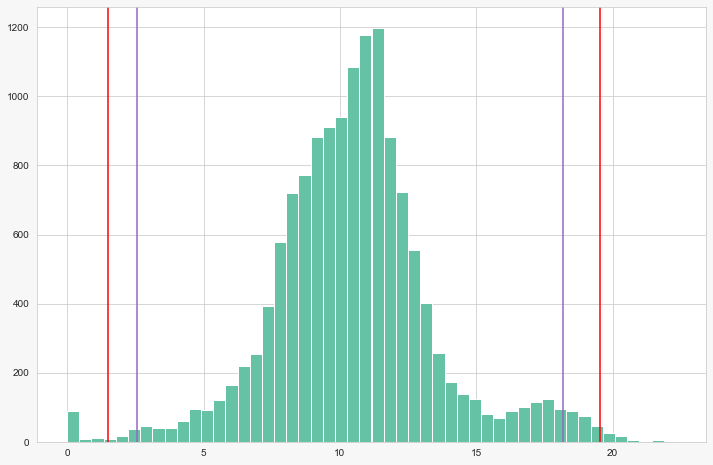

-------  column final.output.tail_au  ----------
Count NaN: 0
Count ZERO: 75
MAX: 8.197408204778785
MIN: 0.0
Границы по IQR: 0.236 ... 5.567
Границы по 3s: 0.207 ... 5.630


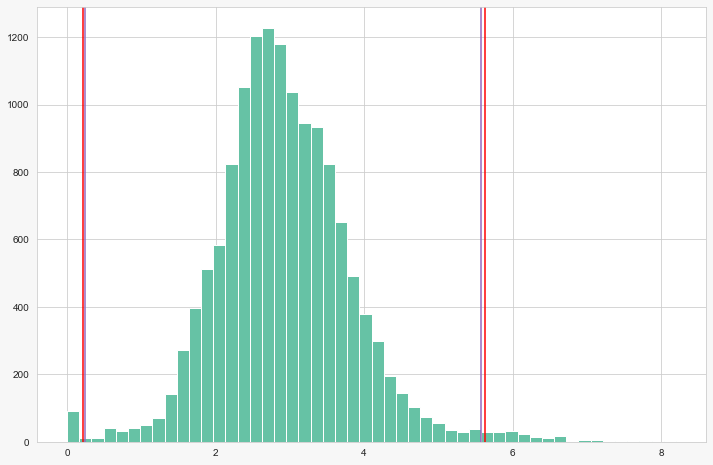

-------  column primary_cleaner.input.sulfate  ----------
Count NaN: 20
Count ZERO: 0
MAX: 250.12783414407448
MIN: 0.0031118198740194
Границы по IQR: 1.369 ... 250.128
Границы по 3s: 15.026 ... 251.616


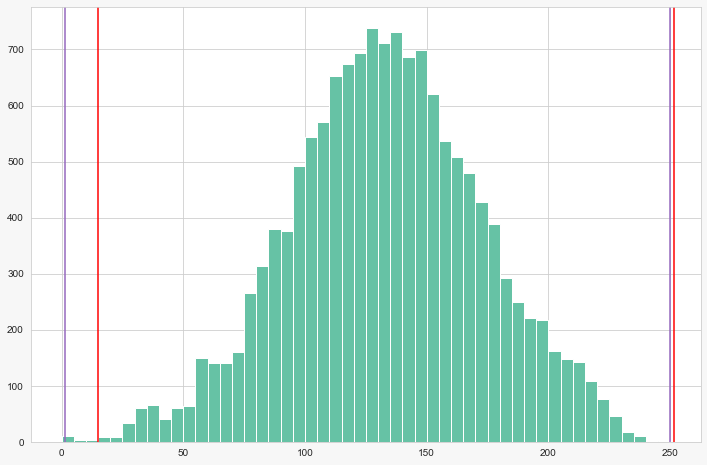

-------  column primary_cleaner.input.depressant  ----------
Count NaN: 32
Count ZERO: 10
MAX: 20.052255429051478
MIN: 0.0
Границы по IQR: 0.000 ... 20.052
Границы по 3s: -1.218 ... 18.952


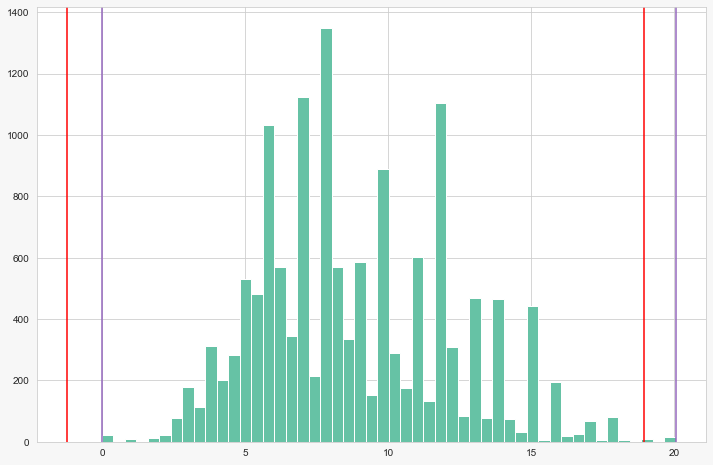

-------  column primary_cleaner.input.feed_size  ----------
Count NaN: 0
Count ZERO: 0
MAX: 10.470000267028809
MIN: 1.0800000429153442
Границы по IQR: 5.480 ... 9.180
Границы по 3s: 5.480 ... 9.164


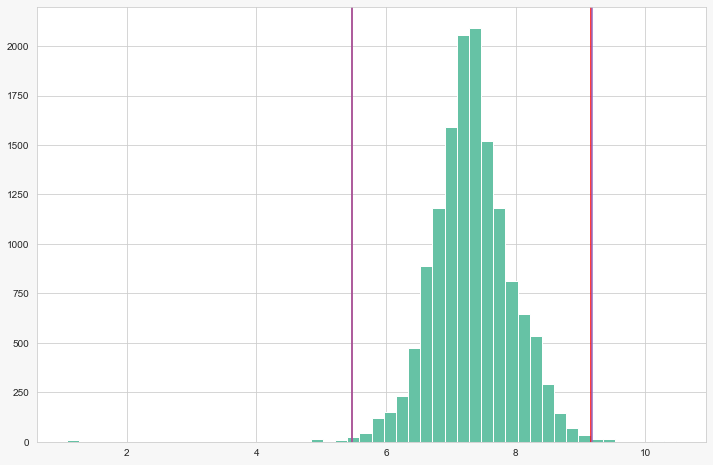

-------  column primary_cleaner.input.xanthate  ----------
Count NaN: 100
Count ZERO: 0
MAX: 2.512968368059389
MIN: 4.632753108427441e-06
Границы по IQR: 0.000 ... 2.089
Границы по 3s: -0.233 ... 2.004


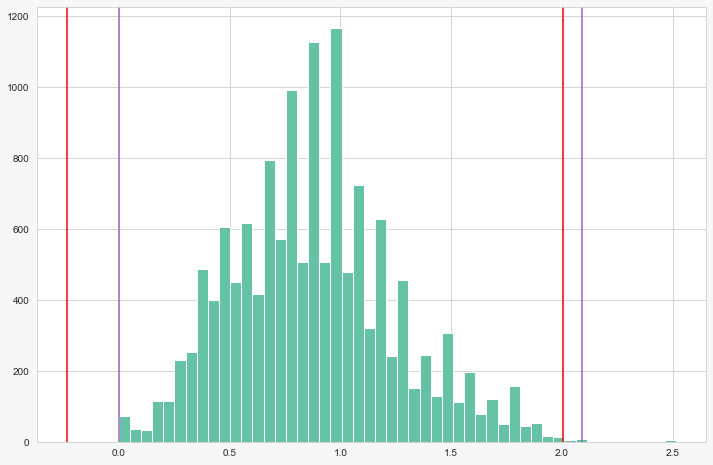

-------  column primary_cleaner.output.concentrate_ag  ----------
Count NaN: 0
Count ZERO: 74
MAX: 16.081631749293688
MIN: 0.0
Границы по IQR: 2.312 ... 14.301
Границы по 3s: 2.185 ... 14.216


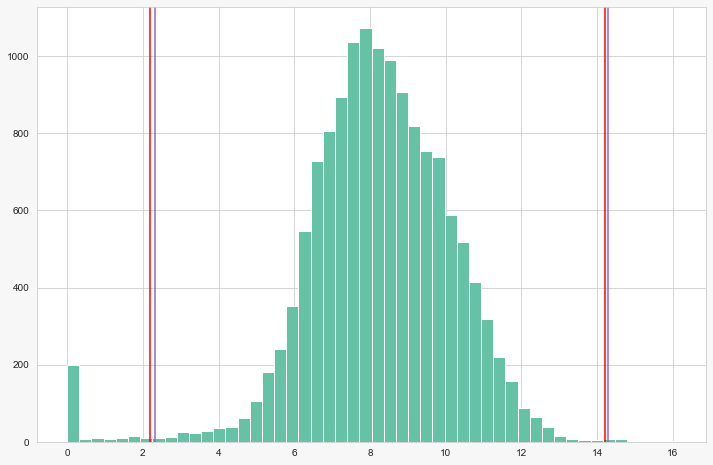

-------  column primary_cleaner.output.concentrate_pb  ----------
Count NaN: 86
Count ZERO: 74
MAX: 17.081278497378033
MIN: 0.0
Границы по IQR: 2.379 ... 17.081
Границы по 3s: 1.506 ... 17.672


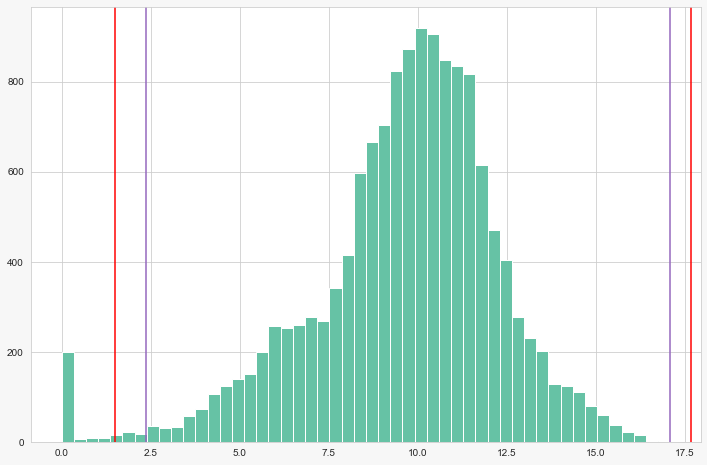

-------  column primary_cleaner.output.concentrate_sol  ----------
Count NaN: 286
Count ZERO: 74
MAX: 22.28084523889753
MIN: 0.0
Границы по IQR: 0.000 ... 22.281
Границы по 3s: -2.077 ... 22.307


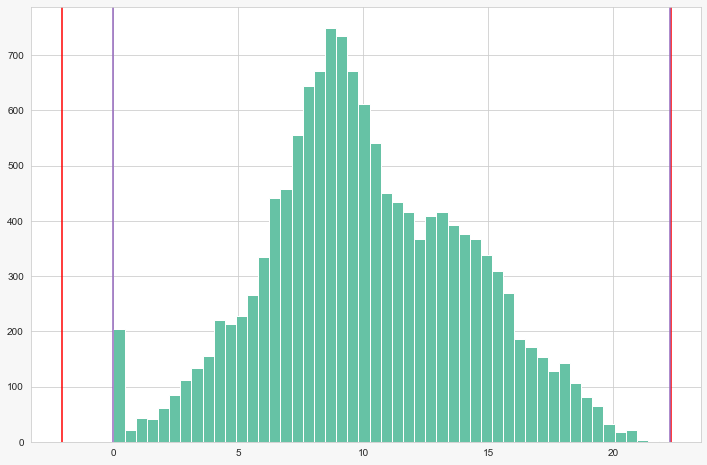

-------  column primary_cleaner.output.concentrate_au  ----------
Count NaN: 0
Count ZERO: 74
MAX: 45.93393406158813
MIN: 0.0
Границы по IQR: 21.913 ... 44.275
Границы по 3s: 14.990 ... 49.783


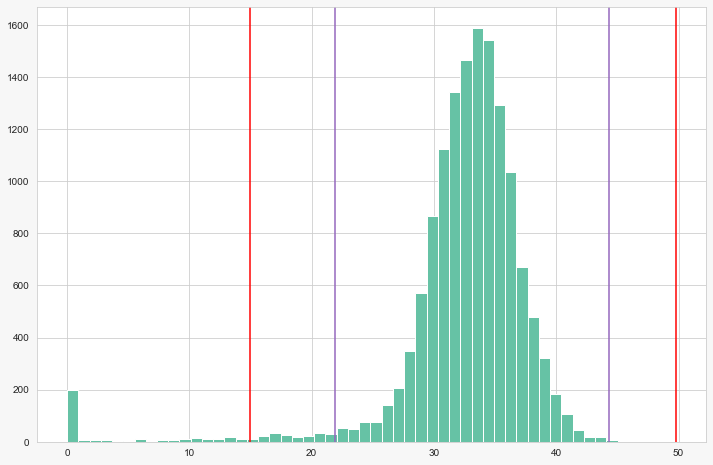

-------  column primary_cleaner.output.tail_ag  ----------
Count NaN: 1
Count ZERO: 68
MAX: 29.459574626549838
MIN: 0.0
Границы по IQR: 4.719 ... 27.604
Границы по 3s: 5.084 ... 27.523


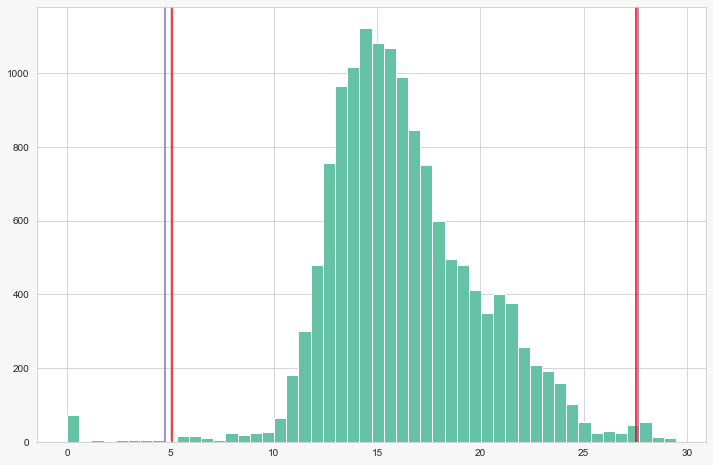

-------  column primary_cleaner.output.tail_pb  ----------
Count NaN: 15
Count ZERO: 68
MAX: 9.634564652972747
MIN: 0.0
Границы по IQR: 0.000 ... 7.919
Границы по 3s: -1.027 ... 7.914


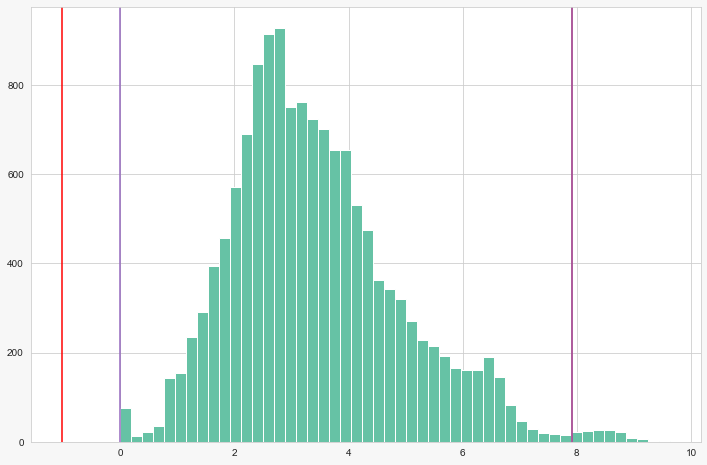

-------  column primary_cleaner.output.tail_sol  ----------
Count NaN: 46
Count ZERO: 68
MAX: 20.620833011803526
MIN: 0.0
Границы по IQR: 1.176 ... 14.067
Границы по 3s: 1.134 ... 13.933


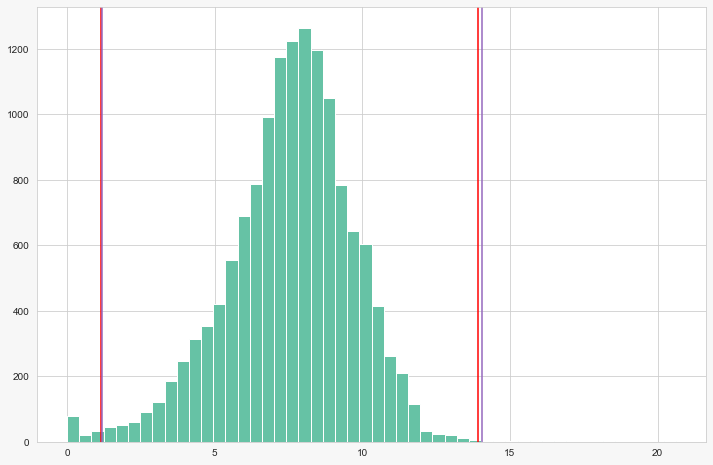

-------  column primary_cleaner.output.tail_au  ----------
Count NaN: 0
Count ZERO: 68
MAX: 17.788924732139996
MIN: 0.0
Границы по IQR: 0.000 ... 7.741
Границы по 3s: -0.971 ... 8.650


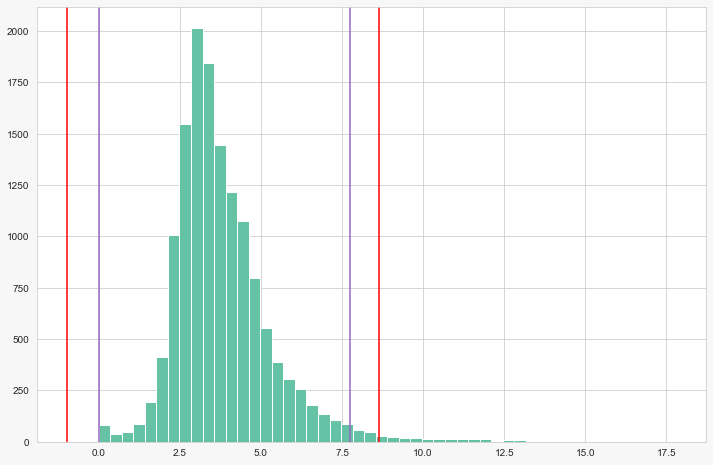

-------  column primary_cleaner.state.floatbank8_a_air  ----------
Count NaN: 4
Count ZERO: 0
MAX: 2079.5313399677634
MIN: 0.0063521546045497
Границы по IQR: 1387.655 ... 1907.758
Границы по 3s: 1222.817 ... 1993.183


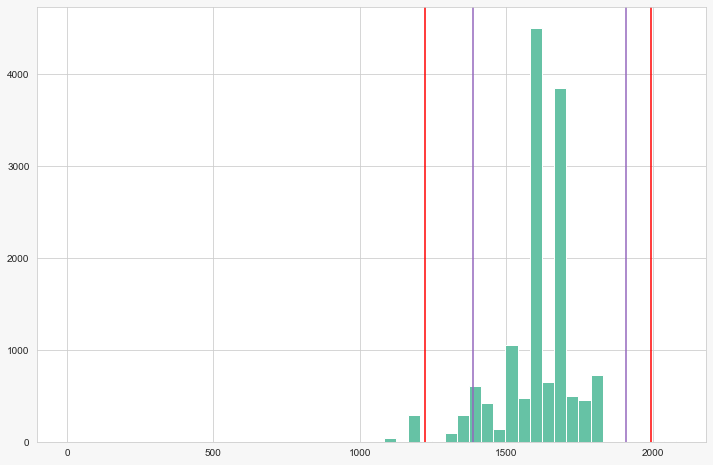

-------  column primary_cleaner.state.floatbank8_a_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -330.13420267663867
MIN: -798.641661561005
Границы по IQR: -502.107 ... -497.560
Границы по 3s: -595.888 ... -381.663


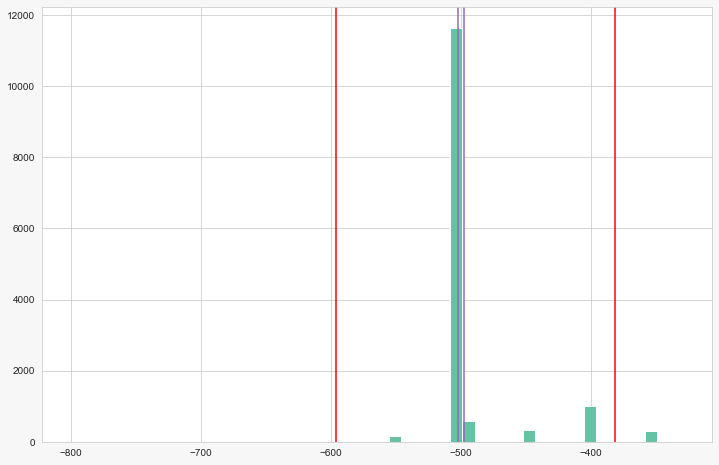

-------  column primary_cleaner.state.floatbank8_b_air  ----------
Count NaN: 4
Count ZERO: 0
MAX: 2114.906758005358
MIN: 0.0087004158447526
Границы по IQR: 1276.449 ... 1982.726
Границы по 3s: 1215.273 ... 2001.949


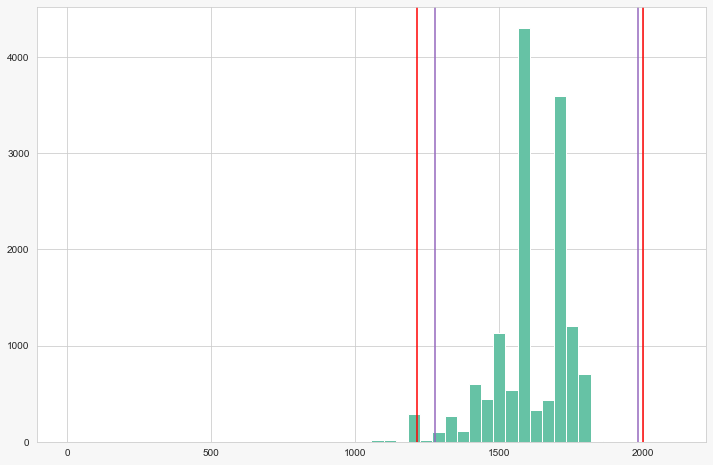

-------  column primary_cleaner.state.floatbank8_b_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -347.3543797848756
MIN: -740.1221290405414
Границы по IQR: -502.348 ... -497.418
Границы по 3s: -589.985 ... -388.358


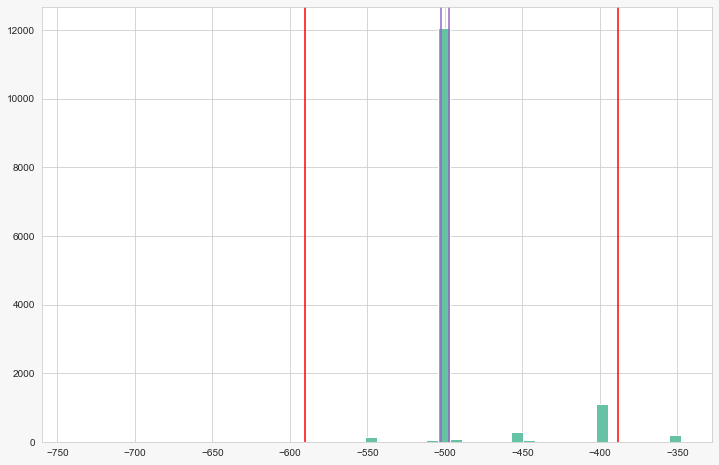

-------  column primary_cleaner.state.floatbank8_c_air  ----------
Count NaN: 2
Count ZERO: 0
MAX: 2013.1564570712965
MIN: 0.0151588211591271
Границы по IQR: 1248.688 ... 2001.648
Границы по 3s: 1206.079 ... 2011.680


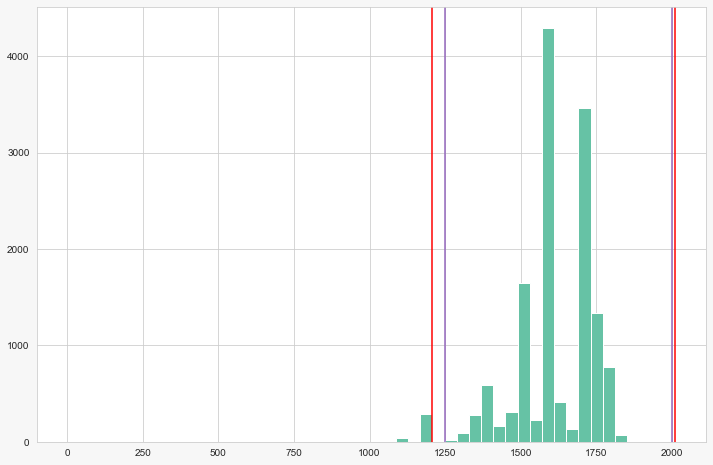

-------  column primary_cleaner.state.floatbank8_c_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -346.6534498040401
MIN: -799.8030728238956
Границы по IQR: -504.202 ... -495.202
Границы по 3s: -596.478 ... -382.734


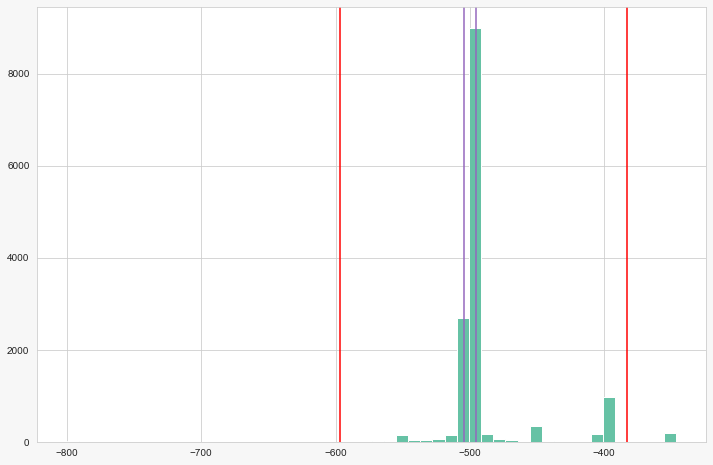

-------  column primary_cleaner.state.floatbank8_d_air  ----------
Count NaN: 3
Count ZERO: 0
MAX: 2398.903635360293
MIN: 0.0086546087844756
Границы по IQR: 959.319 ... 2192.719
Границы по 3s: 707.242 ... 2377.138


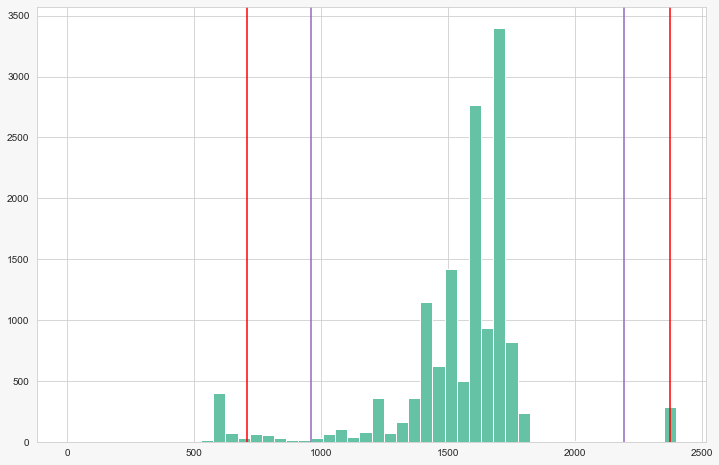

-------  column primary_cleaner.state.floatbank8_d_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -30.60182764875876
MIN: -799.7885975345242
Границы по IQR: -504.419 ... -494.521
Границы по 3s: -624.765 ... -342.160


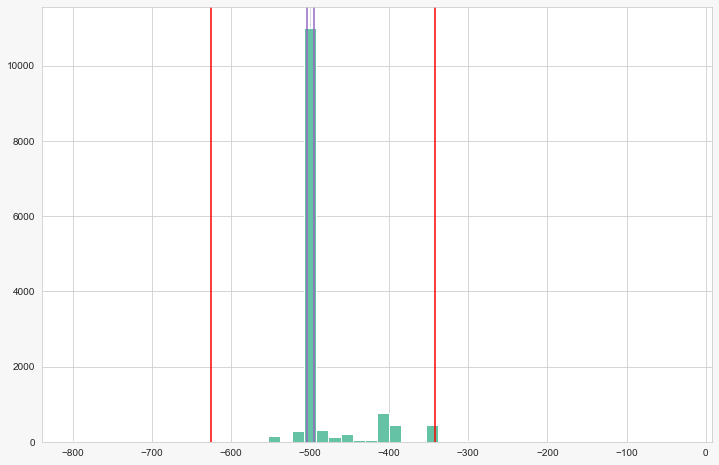

-------  column rougher.calculation.sulfate_to_au_concentrate  ----------
Count NaN: 1
Count ZERO: 0
MAX: 3428098.9389996207
MIN: -42235197.36918358
Границы по IQR: 24462.075 ... 63292.628
Границы по 3s: -1100048.218 ... 1180813.515


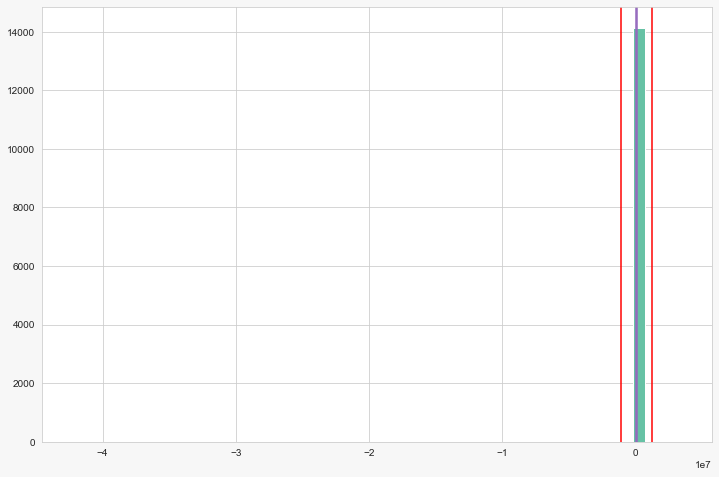

-------  column rougher.calculation.floatbank10_sulfate_to_au_feed  ----------
Count NaN: 1
Count ZERO: 0
MAX: 629638.9779140438
MIN: -486.5986753054797
Границы по IQR: 148.558 ... 6094.896
Границы по 3s: -13860.922 ... 20774.139


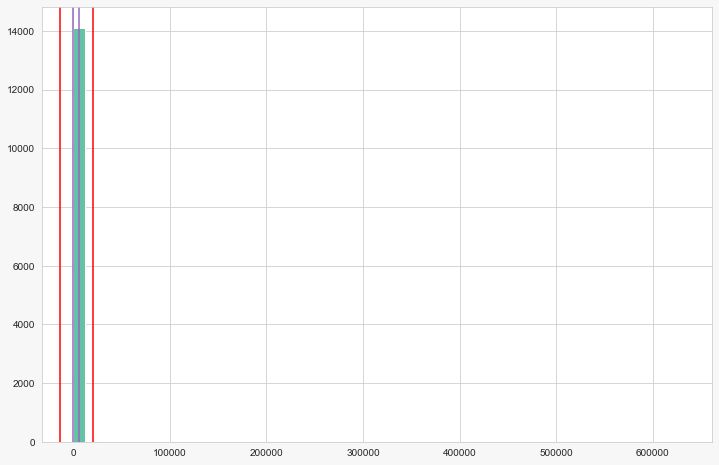

-------  column rougher.calculation.floatbank11_sulfate_to_au_feed  ----------
Count NaN: 1
Count ZERO: 0
MAX: 718684.9558548755
MIN: -264.9827850134316
Границы по IQR: 343.533 ... 5765.203
Границы по 3s: -17006.516 ... 23513.228


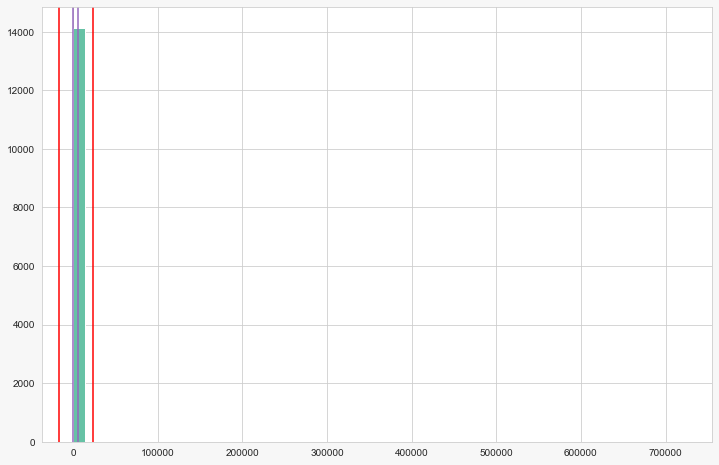

-------  column rougher.calculation.au_pb_ratio  ----------
Count NaN: 0
Count ZERO: 0
MAX: 39.37927198484917
MIN: -0.0105476129695348
Границы по IQR: 0.677 ... 3.984
Границы по 3s: -0.253 ... 4.988


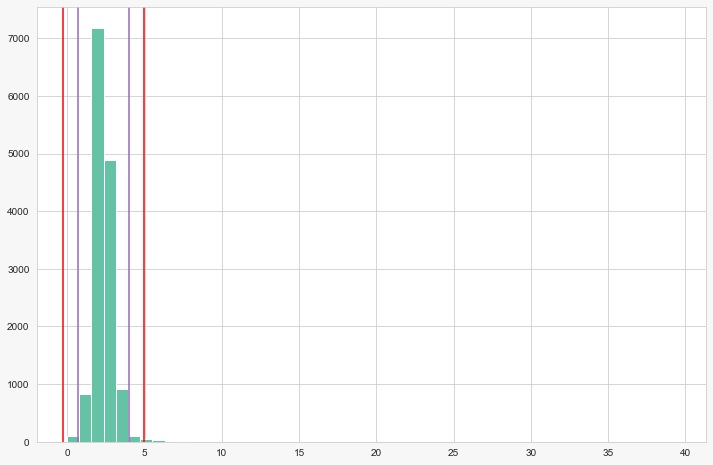

-------  column rougher.input.feed_ag  ----------
Count NaN: 0
Count ZERO: 0
MAX: 14.596025956842716
MIN: 0.0099999997764825
Границы по IQR: 1.562 ... 14.596
Границы по 3s: 2.890 ... 14.268


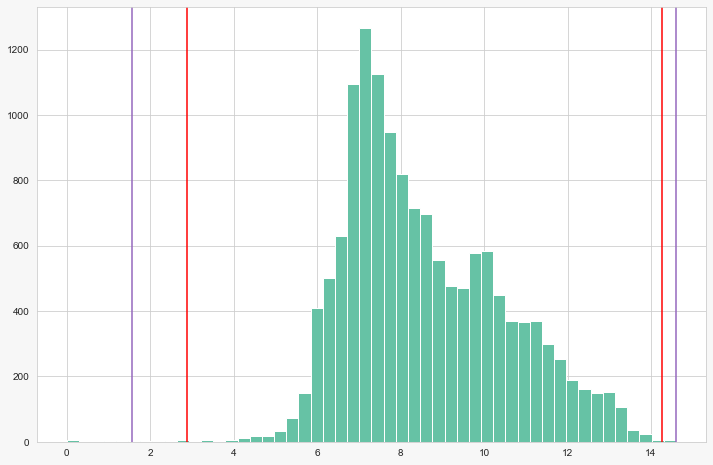

-------  column rougher.input.feed_pb  ----------
Count NaN: 100
Count ZERO: 0
MAX: 7.142594103283352
MIN: 0.0099999997764825
Границы по IQR: 0.010 ... 7.118
Границы по 3s: 0.303 ... 6.743


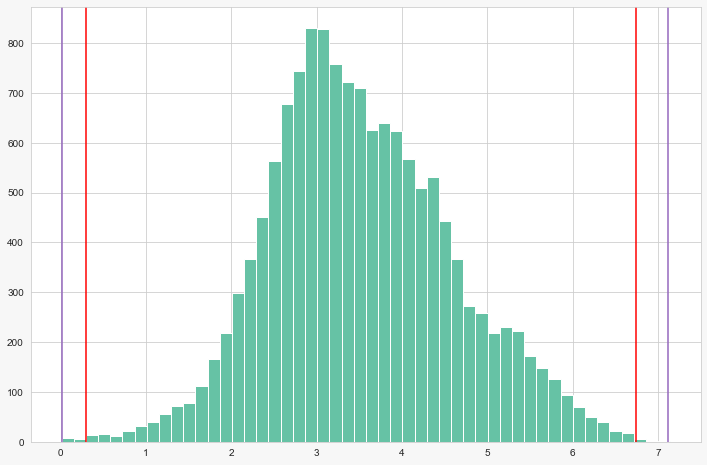

-------  column rougher.input.feed_rate  ----------
Count NaN: 8
Count ZERO: 0
MAX: 717.5088371176428
MIN: 0.0127856991420211
Границы по IQR: 167.676 ... 717.509
Границы по 3s: 161.908 ... 786.147


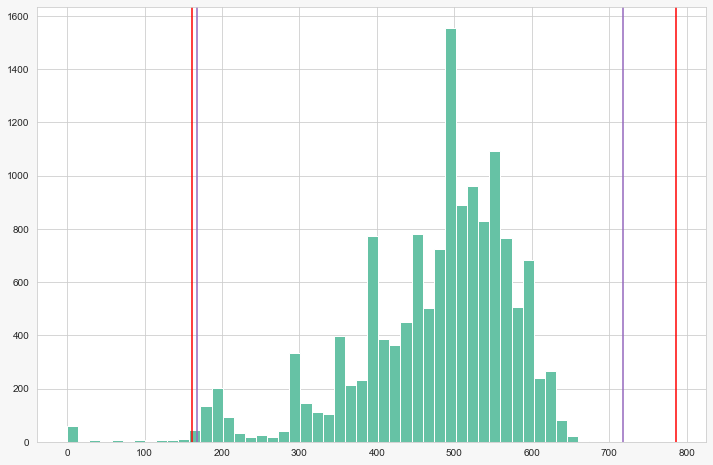

-------  column rougher.input.feed_size  ----------
Count NaN: 144
Count ZERO: 0
MAX: 484.9674664939735
MIN: 9.659576314610517
Границы по IQR: 14.759 ... 100.294
Границы по 3s: -7.145 ... 127.366


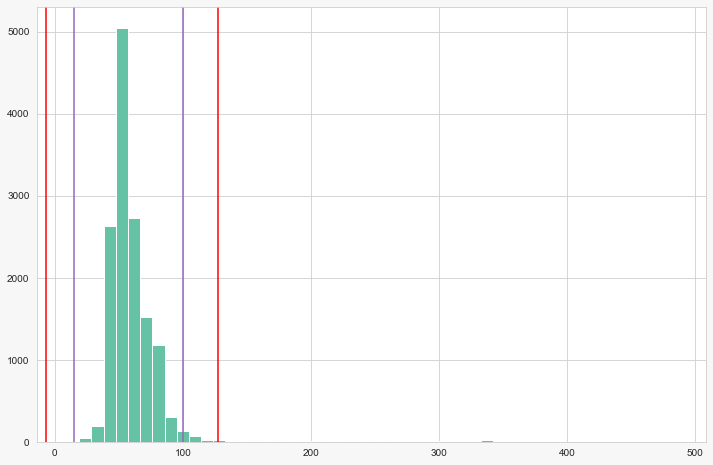

-------  column rougher.input.feed_sol  ----------
Count NaN: 78
Count ZERO: 0
MAX: 48.36317715326946
MIN: 0.0099999997764825
Границы по IQR: 23.506 ... 48.363
Границы по 3s: 21.444 ... 51.181


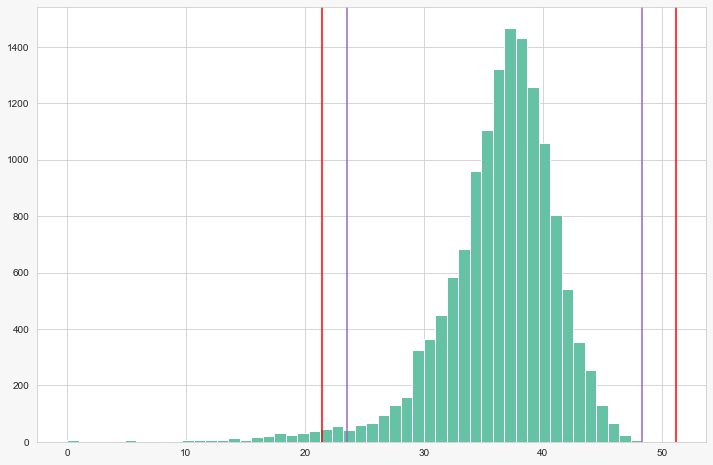

-------  column rougher.input.feed_au  ----------
Count NaN: 0
Count ZERO: 0
MAX: 13.126042672939944
MIN: 0.0099999997764825
Границы по IQR: 1.655 ... 13.126
Границы по 3s: 2.108 ... 13.625


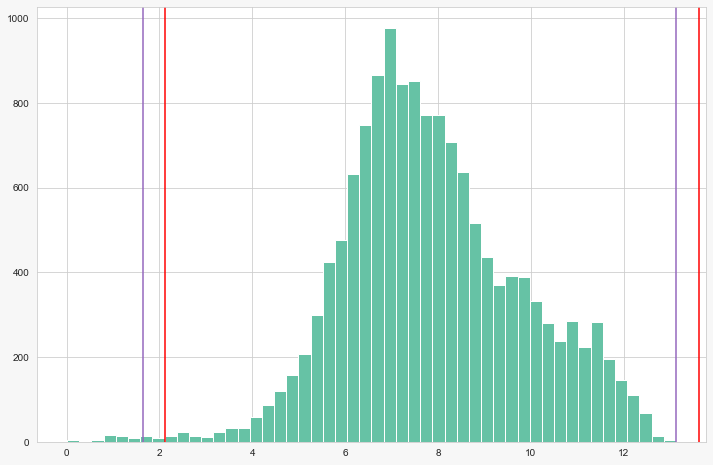

-------  column rougher.input.floatbank10_sulfate  ----------
Count NaN: 29
Count ZERO: 0
MAX: 36.11827473927608
MIN: 0.0010831123366383
Границы по IQR: 2.369 ... 21.099
Границы по 3s: 1.928 ... 21.601


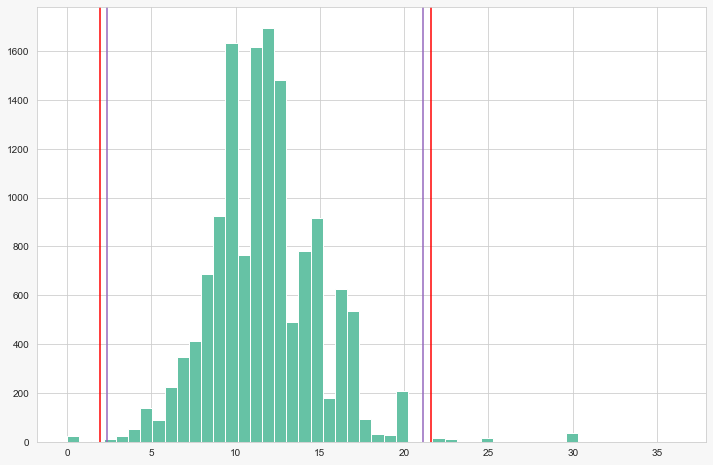

-------  column rougher.input.floatbank10_xanthate  ----------
Count NaN: 8
Count ZERO: 0
MAX: 9.703448040845032
MIN: 0.0014276846764186
Границы по IQR: 2.147 ... 9.573
Границы по 3s: 2.542 ... 9.167


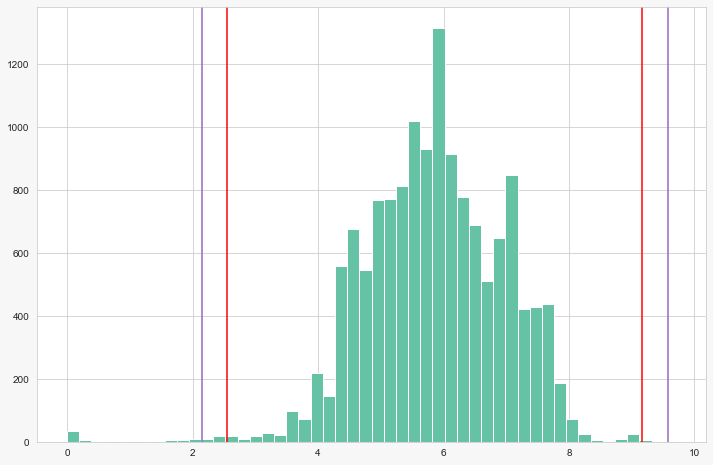

-------  column rougher.input.floatbank11_sulfate  ----------
Count NaN: 36
Count ZERO: 0
MAX: 37.980647881026265
MIN: 9.787336238683812e-05
Границы по IQR: 1.522 ... 21.480
Границы по 3s: 0.138 ... 22.600


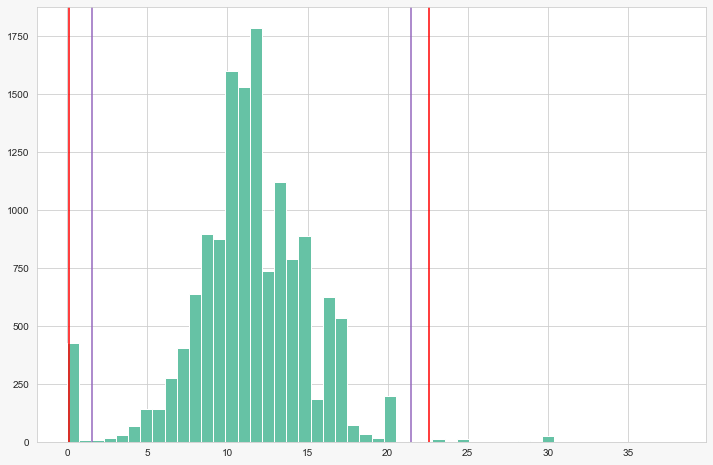

-------  column rougher.input.floatbank11_xanthate  ----------
Count NaN: 428
Count ZERO: 0
MAX: 9.698406867732444
MIN: 0.0002904125738132
Границы по IQR: 2.199 ... 9.698
Границы по 3s: 2.521 ... 9.267


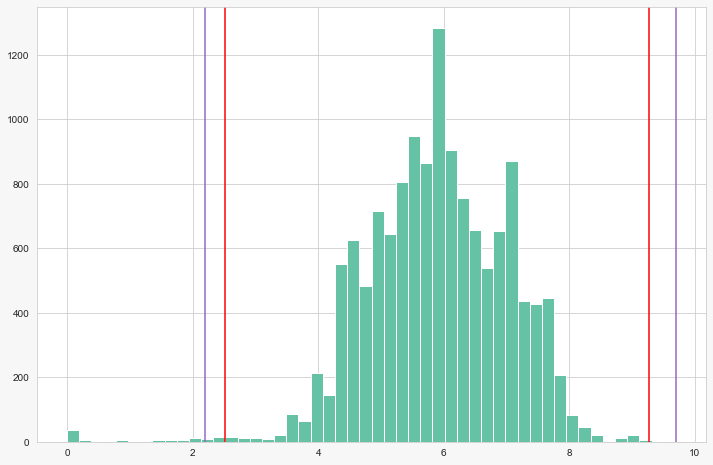

-------  column rougher.output.concentrate_ag  ----------
Count NaN: 0
Count ZERO: 297
MAX: 24.48027094510577
MIN: 0.0
Границы по IQR: 4.608 ... 19.306
Границы по 3s: 3.581 ... 19.971


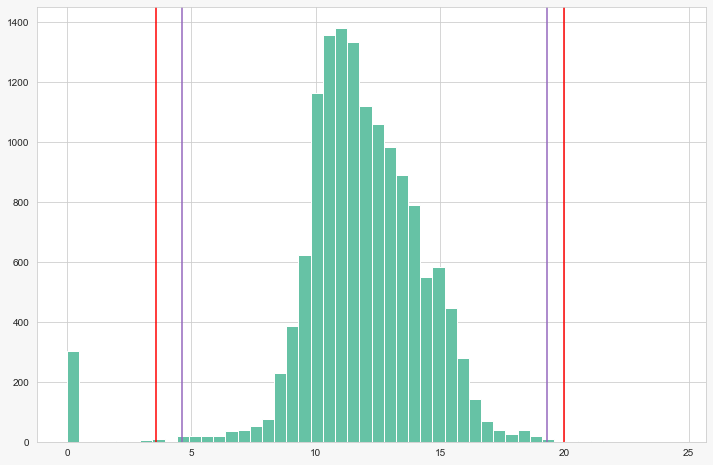

-------  column rougher.output.concentrate_pb  ----------
Count NaN: 0
Count ZERO: 297
MAX: 13.6170719165148
MIN: 0.0
Границы по IQR: 3.348 ... 12.105
Границы по 3s: 2.096 ... 13.233


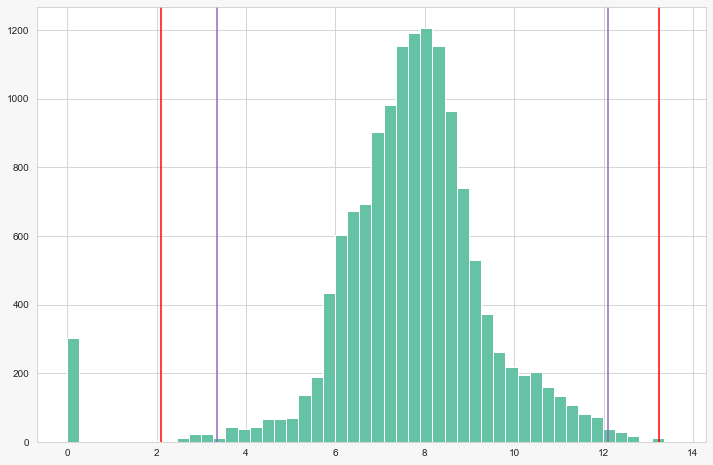

-------  column rougher.output.concentrate_sol  ----------
Count NaN: 22
Count ZERO: 297
MAX: 38.351192848417504
MIN: 0.0
Границы по IQR: 16.623 ... 38.351
Границы по 3s: 9.994 ... 46.612


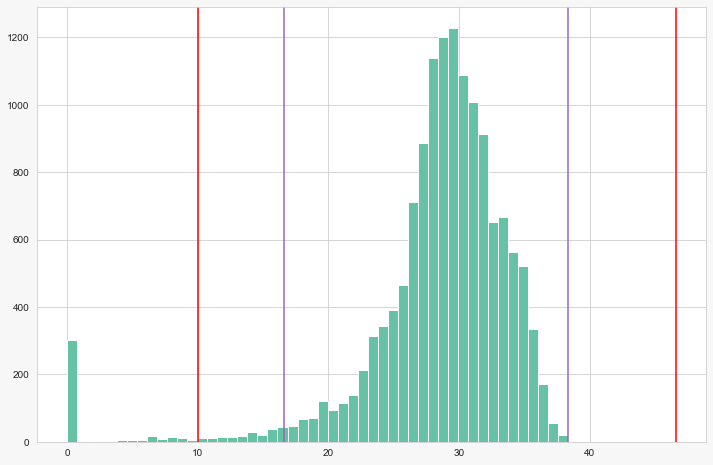

-------  column rougher.output.concentrate_au  ----------
Count NaN: 0
Count ZERO: 297
MAX: 28.146837606874488
MIN: 0.0
Границы по IQR: 12.511 ... 27.314
Границы по 3s: 8.144 ... 30.736


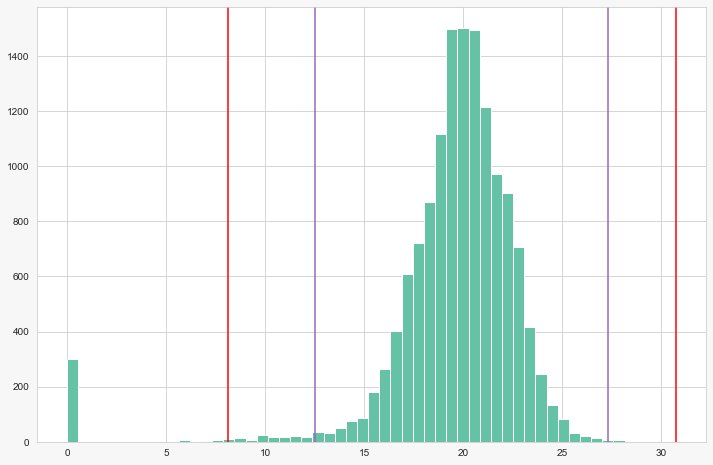

-------  column rougher.output.recovery  ----------
Count NaN: 0
Count ZERO: 297
MAX: 100.0
MIN: 0.0
Границы по IQR: 59.649 ... 100.000
Границы по 3s: 39.267 ... 126.142


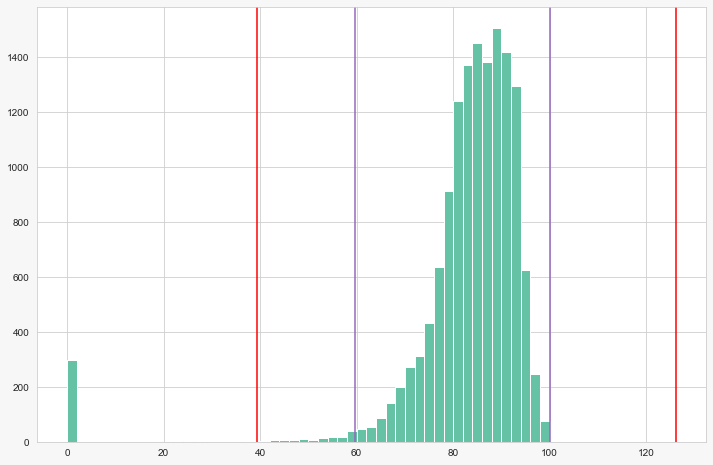

-------  column rougher.output.tail_ag  ----------
Count NaN: 1
Count ZERO: 0
MAX: 12.71917683245339
MIN: 0.594562292098999
Границы по IQR: 2.144 ... 9.089
Границы по 3s: 2.450 ... 8.685


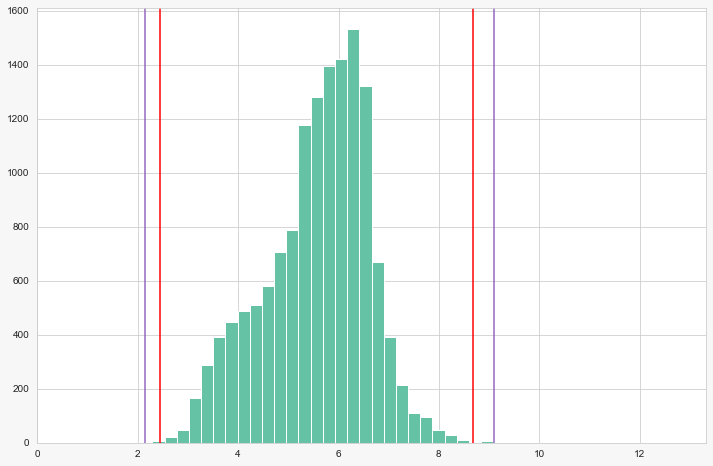

-------  column rougher.output.tail_pb  ----------
Count NaN: 0
Count ZERO: 0
MAX: 3.778063771520845
MIN: 0.0075660659822945
Границы по IQR: 0.008 ... 1.435
Границы по 3s: -0.138 ... 1.445


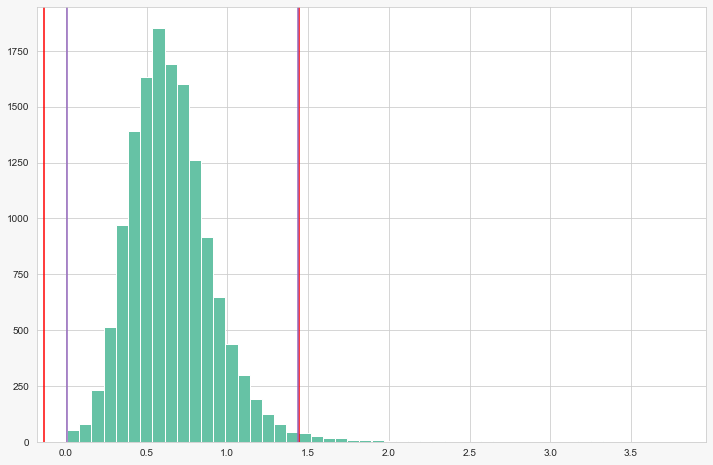

-------  column rougher.output.tail_sol  ----------
Count NaN: 0
Count ZERO: 0
MAX: 66.1171875
MIN: 10.0146484375
Границы по IQR: 10.015 ... 28.439
Границы по 3s: 7.584 ... 28.181


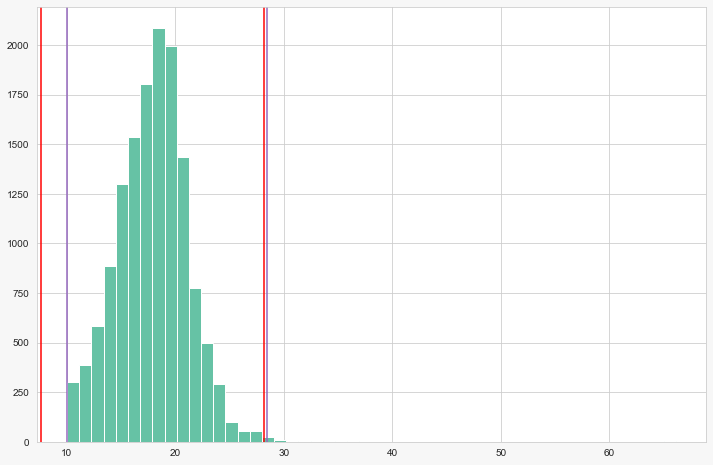

-------  column rougher.output.tail_au  ----------
Count NaN: 0
Count ZERO: 0
MAX: 9.688979686468633
MIN: 0.0206757791548096
Границы по IQR: 0.021 ... 3.939
Границы по 3s: -0.382 ... 3.897


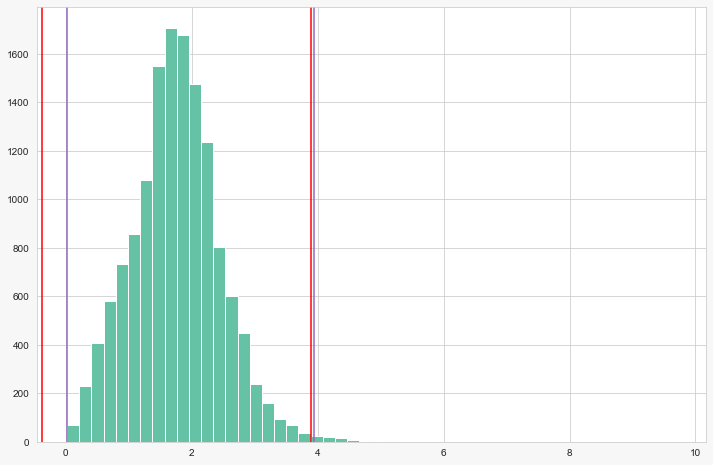

-------  column rougher.state.floatbank10_a_air  ----------
Count NaN: 1
Count ZERO: 0
MAX: 1521.980372240213
MIN: -0.0410779188834095
Границы по IQR: 400.386 ... 1521.980
Границы по 3s: 616.794 ... 1632.659


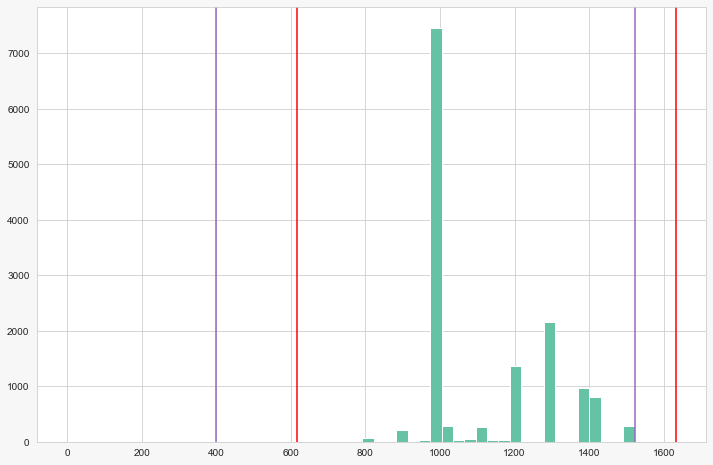

-------  column rougher.state.floatbank10_a_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -281.0392985430529
MIN: -650.2028808194036
Границы по IQR: -650.203 ... -281.039
Границы по 3s: -651.319 ... -87.603


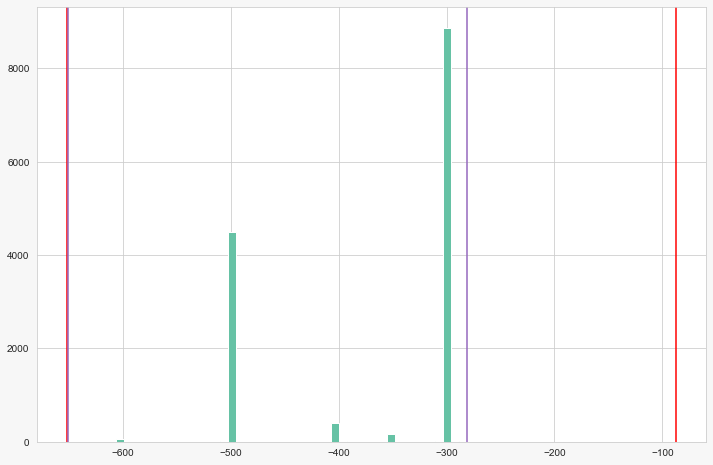

-------  column rougher.state.floatbank10_b_air  ----------
Count NaN: 1
Count ZERO: 0
MAX: 1809.1940080011784
MIN: -0.6533838308011395
Границы по IQR: 698.992 ... 1809.194
Границы по 3s: 771.237 ... 1870.173


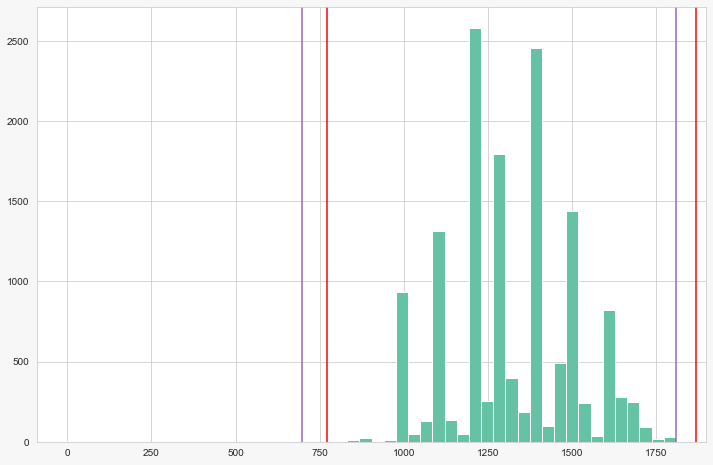

-------  column rougher.state.floatbank10_b_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -296.3830799637267
MIN: -650.2600075387917
Границы по IQR: -650.260 ... -296.383
Границы по 3s: -636.465 ... -292.053


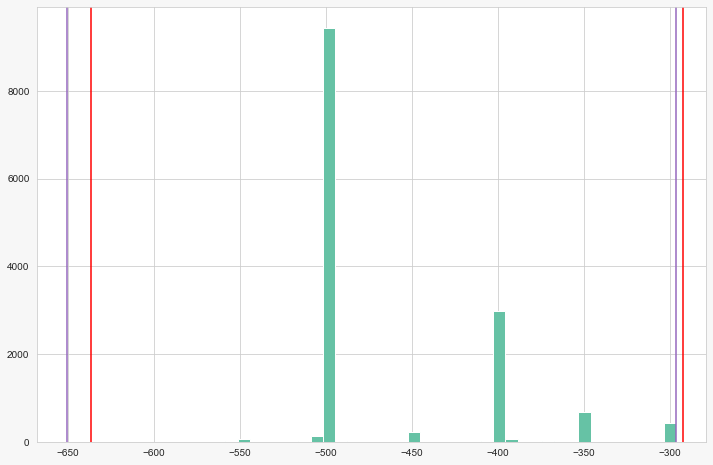

-------  column rougher.state.floatbank10_c_air  ----------
Count NaN: 1
Count ZERO: 0
MAX: 2499.1291741005434
MIN: -0.0351123302814346
Границы по IQR: 408.584 ... 2144.862
Границы по 3s: 659.148 ... 1939.573


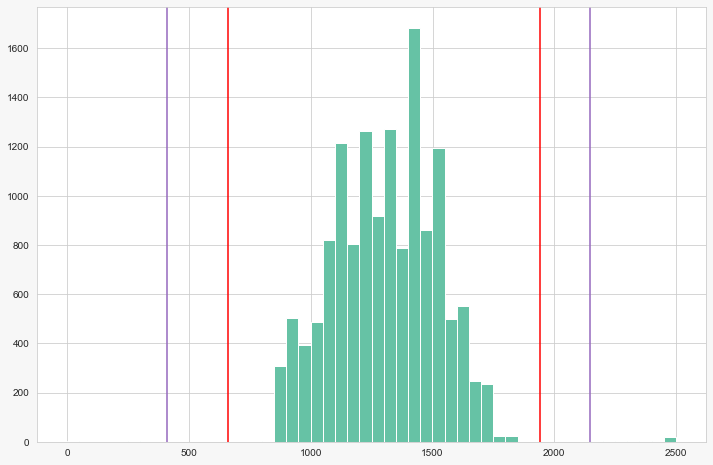

-------  column rougher.state.floatbank10_c_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -292.15550876811045
MIN: -640.9956273638282
Границы по IQR: -640.996 ... -292.156
Границы по 3s: -632.769 ... -297.341


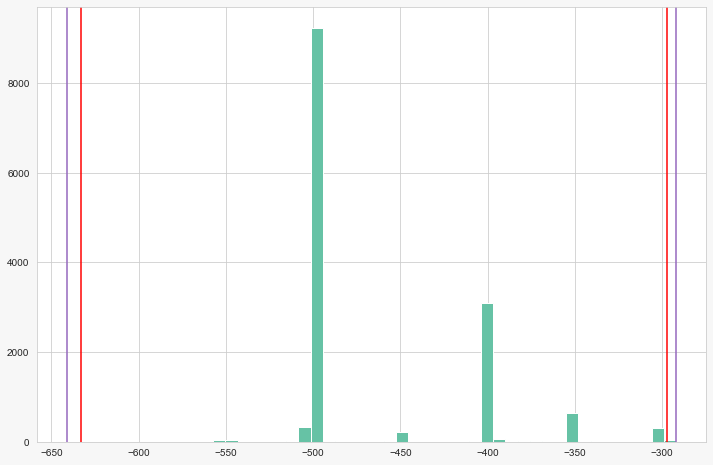

-------  column rougher.state.floatbank10_d_air  ----------
Count NaN: 0
Count ZERO: 0
MAX: 1817.199290476136
MIN: -0.5542986530066452
Границы по IQR: 490.369 ... 1817.199
Границы по 3s: 579.041 ... 1841.630


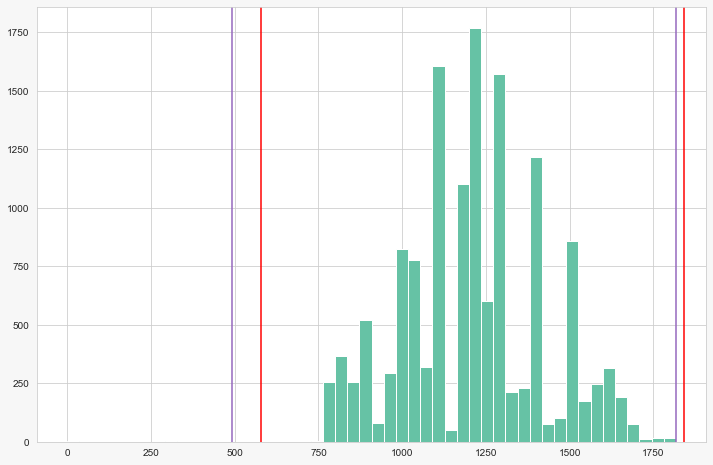

-------  column rougher.state.floatbank10_d_level  ----------
Count NaN: 0
Count ZERO: 0
MAX: -208.33067299038768
MIN: -640.5190028250543
Границы по IQR: -640.519 ... -208.331
Границы по 3s: -632.772 ... -298.143


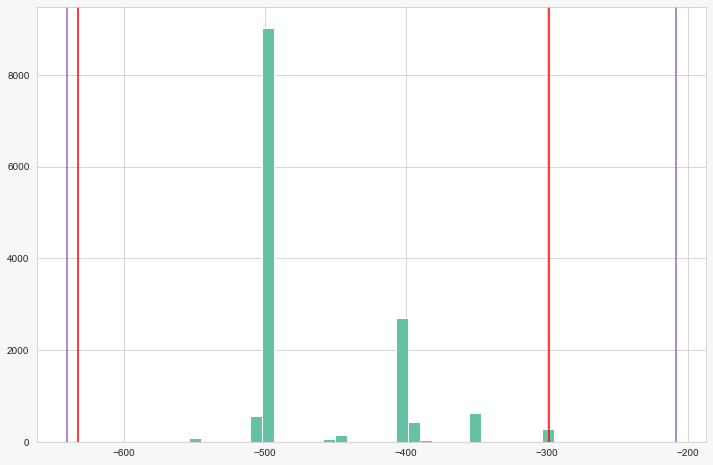

-------  column rougher.state.floatbank10_e_air  ----------
Count NaN: 436
Count ZERO: 0
MAX: 1922.6366366607565
MIN: -1.9702753456295568
Границы по IQR: 591.456 ... 1605.776
Границы по 3s: 536.383 ... 1644.044


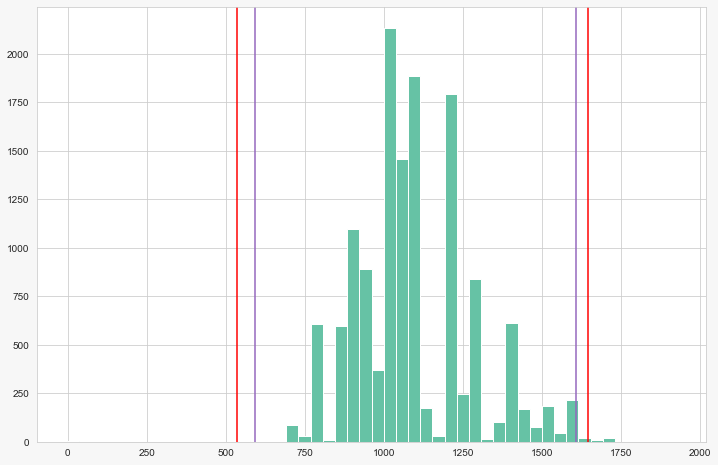

-------  column rougher.state.floatbank10_e_level  ----------
Count NaN: 0
Count ZERO: 0
MAX: -272.19959776453203
MIN: -649.443910909439
Границы по IQR: -649.444 ... -272.200
Границы по 3s: -634.728 ... -295.110


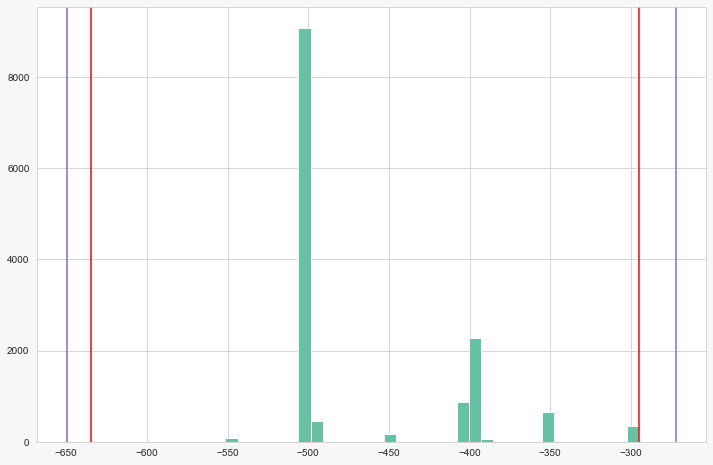

-------  column rougher.state.floatbank10_f_air  ----------
Count NaN: 0
Count ZERO: 0
MAX: 1706.307502416191
MIN: -2.4305872521028933
Границы по IQR: 502.570 ... 1498.562
Границы по 3s: 510.333 ... 1560.647


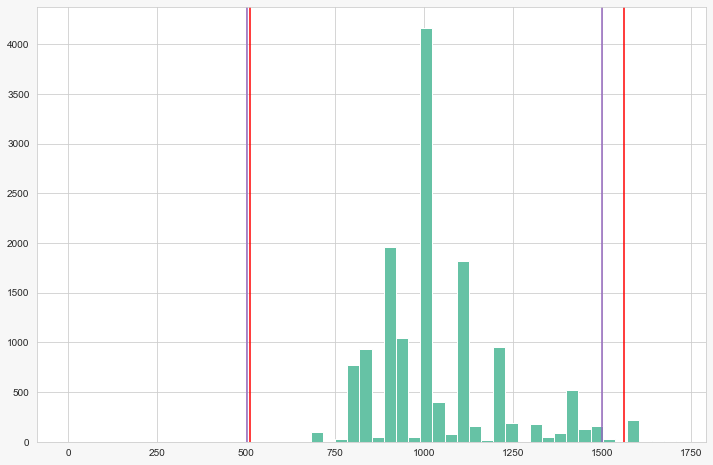

-------  column rougher.state.floatbank10_f_level  ----------
Count NaN: 0
Count ZERO: 0
MAX: -191.7184797717884
MIN: -649.8809814453125
Границы по IQR: -649.881 ... -202.092
Границы по 3s: -634.627 ... -294.751


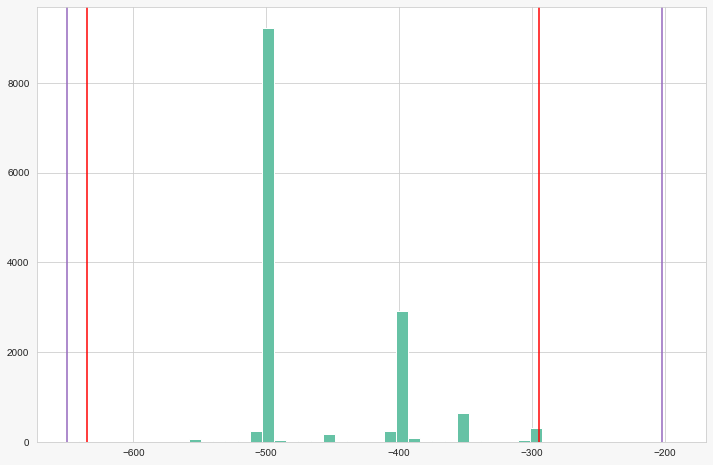

-------  column secondary_cleaner.output.tail_ag  ----------
Count NaN: 2
Count ZERO: 739
MAX: 23.264738336018237
MIN: 0.0
Границы по IQR: 2.072 ... 23.265
Границы по 3s: 0.850 ... 27.713


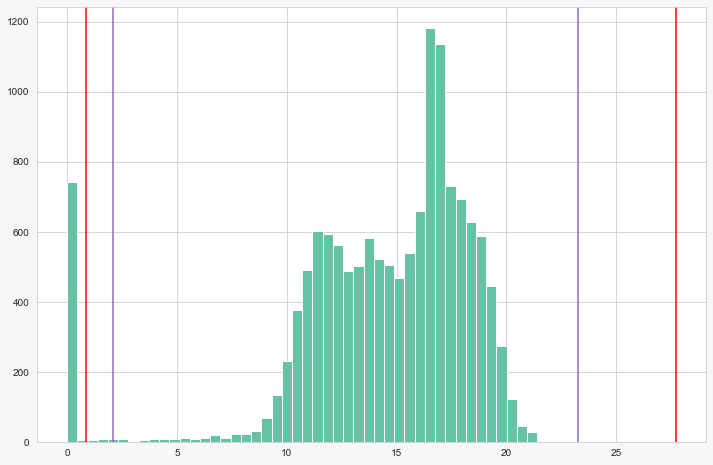

-------  column secondary_cleaner.output.tail_pb  ----------
Count NaN: 10
Count ZERO: 739
MAX: 17.042504875924852
MIN: 0.0
Границы по IQR: 0.000 ... 15.429
Границы по 3s: -2.737 ... 14.434


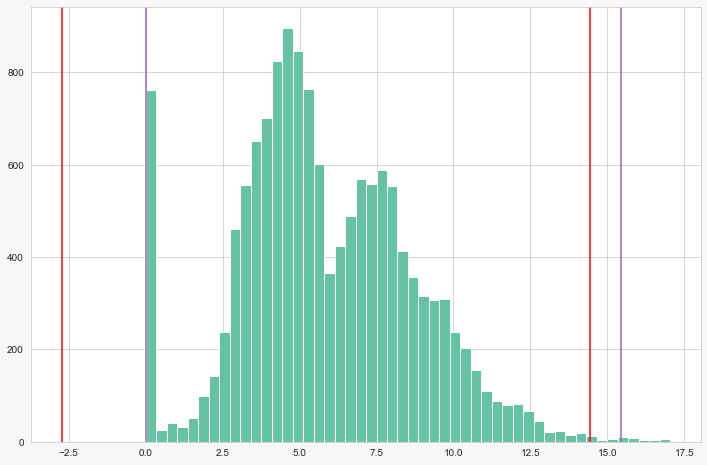

-------  column secondary_cleaner.output.tail_sol  ----------
Count NaN: 1605
Count ZERO: 739
MAX: 17.976171024640397
MIN: 0.0
Границы по IQR: 0.000 ... 17.976
Границы по 3s: -5.528 ... 19.405


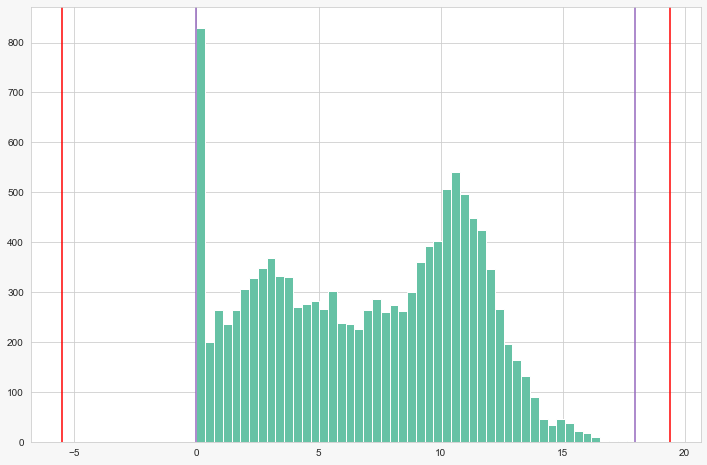

-------  column secondary_cleaner.output.tail_au  ----------
Count NaN: 0
Count ZERO: 739
MAX: 26.81164286593949
MIN: 0.0
Границы по IQR: 0.000 ... 8.346
Границы по 3s: -2.920 ... 11.414


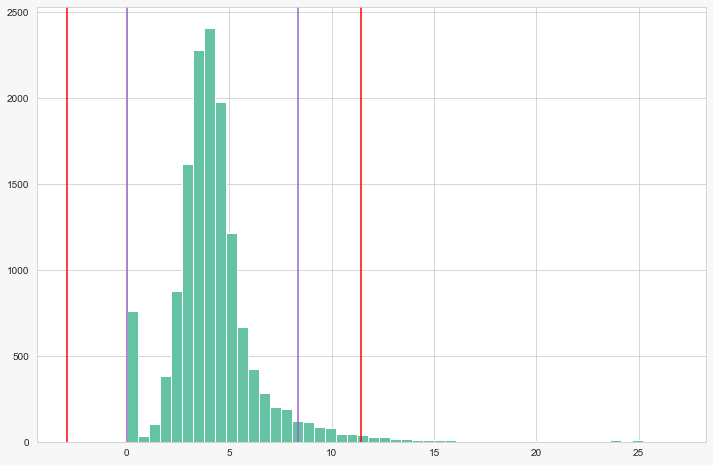

-------  column secondary_cleaner.state.floatbank2_a_air  ----------
Count NaN: 217
Count ZERO: 0
MAX: 52.65139882162119
MIN: 0.0775025574958832
Границы по IQR: 5.513 ... 52.651
Границы по 3s: 12.212 ... 47.015


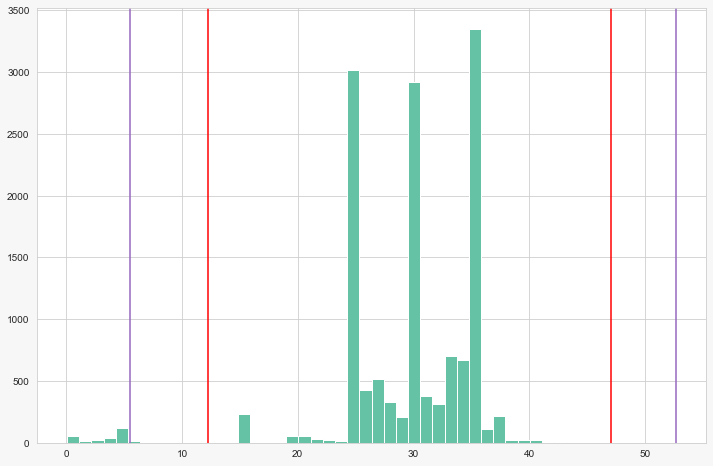

-------  column secondary_cleaner.state.floatbank2_a_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -127.87556529194616
MIN: -799.6064406505061
Границы по IQR: -501.560 ... -498.282
Границы по 3s: -683.069 ... -321.379


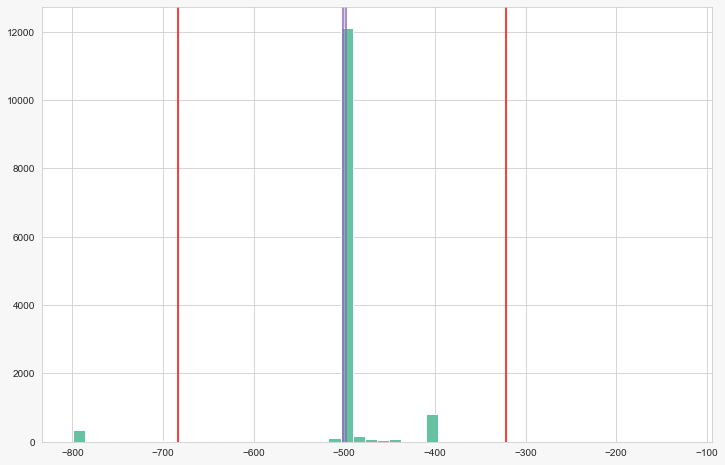

-------  column secondary_cleaner.state.floatbank2_b_air  ----------
Count NaN: 21
Count ZERO: 8
MAX: 35.15212196778239
MIN: 0.0
Границы по IQR: 8.266 ... 35.152
Границы по 3s: 6.930 ... 42.899


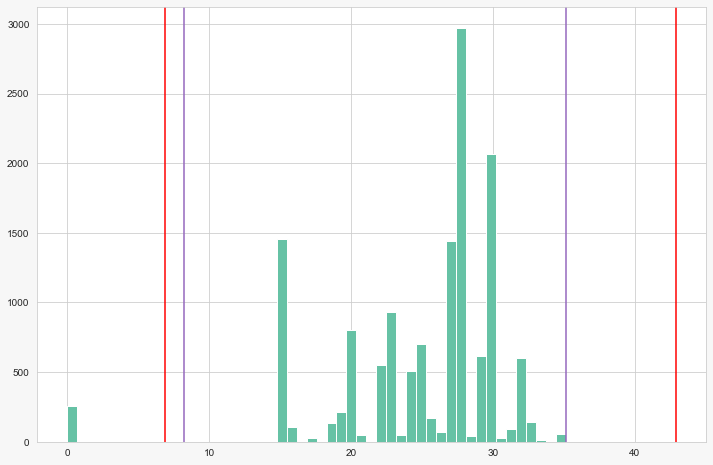

-------  column secondary_cleaner.state.floatbank2_b_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -212.06466513912412
MIN: -799.8738782248871
Границы по IQR: -501.285 ... -498.750
Границы по 3s: -692.208 ... -315.184


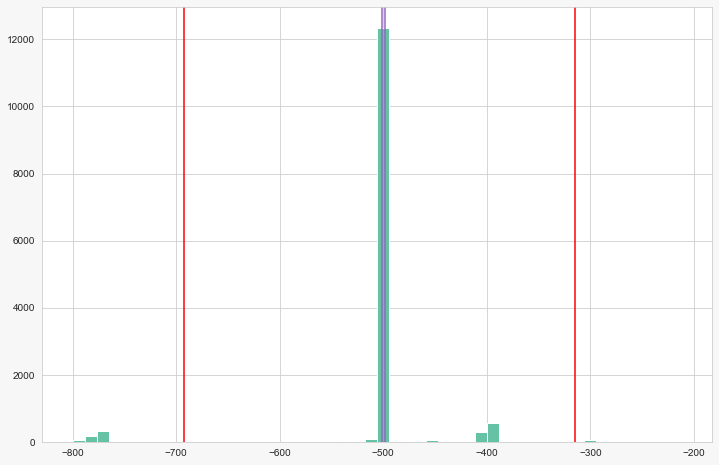

-------  column secondary_cleaner.state.floatbank3_a_air  ----------
Count NaN: 4
Count ZERO: 1
MAX: 44.26046364951683
MIN: 0.0
Границы по IQR: 4.995 ... 44.260
Границы по 3s: 12.331 ... 46.155


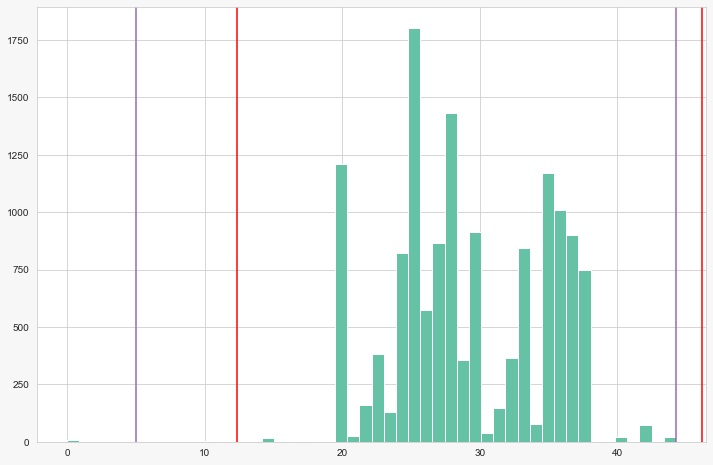

-------  column secondary_cleaner.state.floatbank3_a_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -191.67881012625705
MIN: -799.6130133845363
Границы по IQR: -626.679 ... -310.419
Границы по 3s: -642.209 ... -314.279


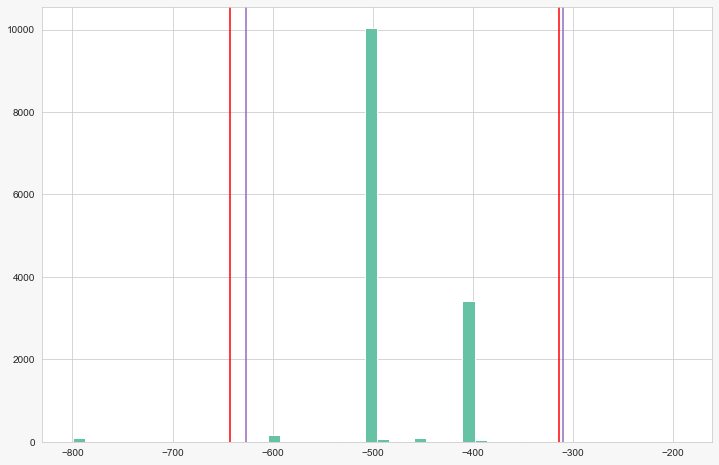

-------  column secondary_cleaner.state.floatbank3_b_air  ----------
Count NaN: 1
Count ZERO: 1
MAX: 35.072840627699605
MIN: 0.0
Границы по IQR: 7.905 ... 35.073
Границы по 3s: 7.668 ... 37.644


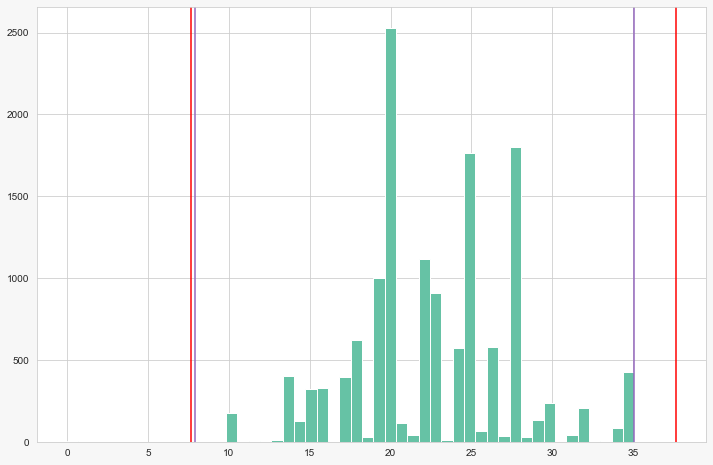

-------  column secondary_cleaner.state.floatbank3_b_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -159.74233084492997
MIN: -759.1773808972199
Границы по IQR: -500.817 ... -499.051
Границы по 3s: -614.708 ... -363.140


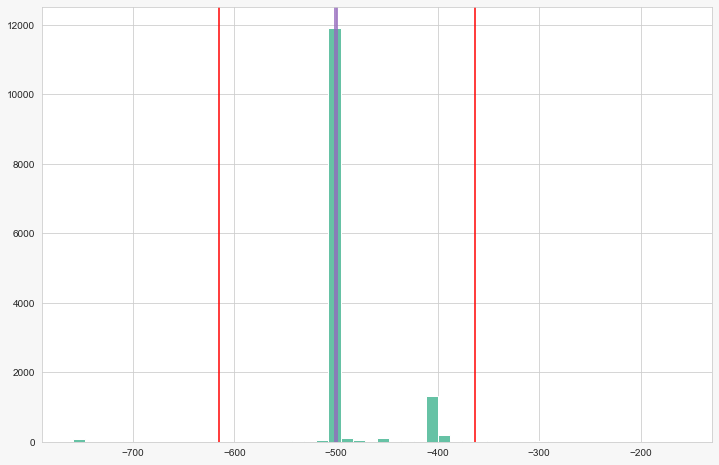

-------  column secondary_cleaner.state.floatbank4_a_air  ----------
Count NaN: 6
Count ZERO: 1
MAX: 30.115735428726765
MIN: 0.0
Границы по IQR: 0.000 ... 30.116
Границы по 3s: 3.012 ... 36.959


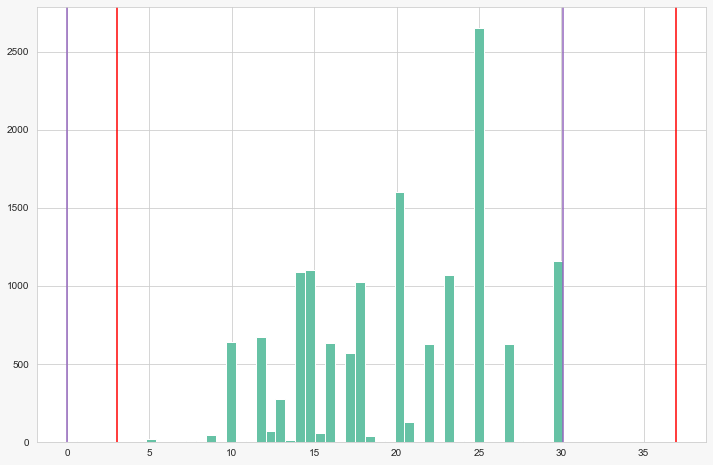

-------  column secondary_cleaner.state.floatbank4_a_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -245.23918367959504
MIN: -799.7090690926949
Границы по IQR: -546.941 ... -431.160
Границы по 3s: -630.905 ... -326.489


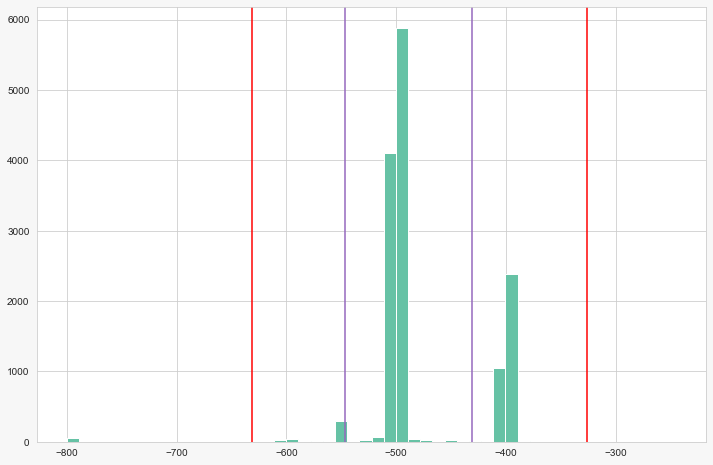

-------  column secondary_cleaner.state.floatbank4_b_air  ----------
Count NaN: 1
Count ZERO: 1
MAX: 24.00791269093764
MIN: 0.0
Границы по IQR: 0.000 ... 24.008
Границы по 3s: -0.280 ... 31.254


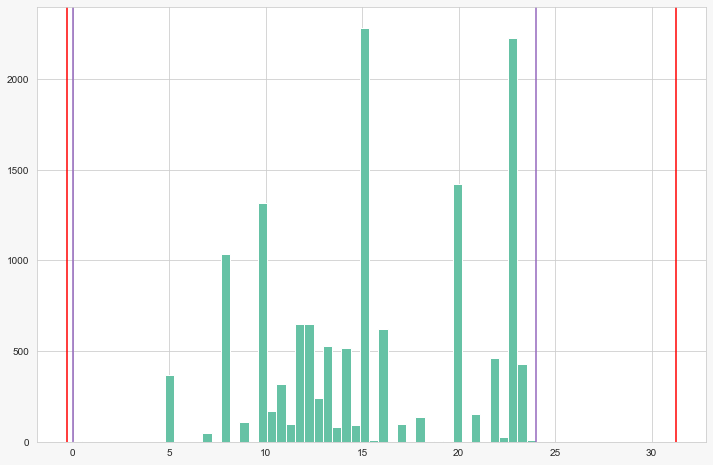

-------  column secondary_cleaner.state.floatbank4_b_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -145.07108810972608
MIN: -799.8891125454303
Границы по IQR: -700.369 ... -199.819
Границы по 3s: -636.760 ... -283.699


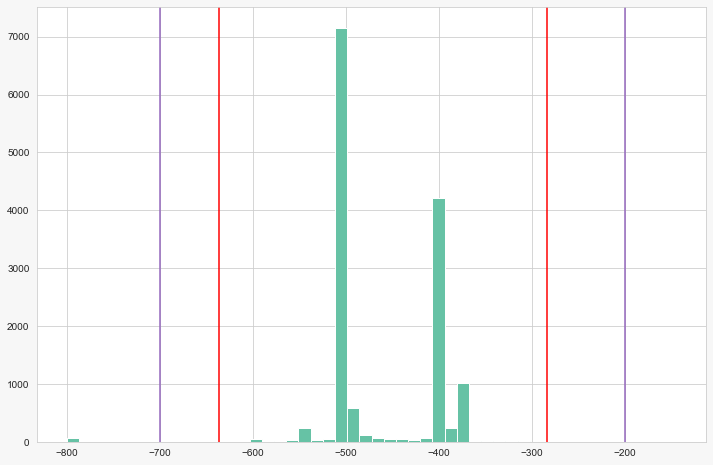

-------  column secondary_cleaner.state.floatbank5_a_air  ----------
Count NaN: 1
Count ZERO: 0
MAX: 43.70993097932247
MIN: -0.3720539853057329
Границы по IQR: -0.372 ... 41.872
Границы по 3s: -0.721 ... 34.271


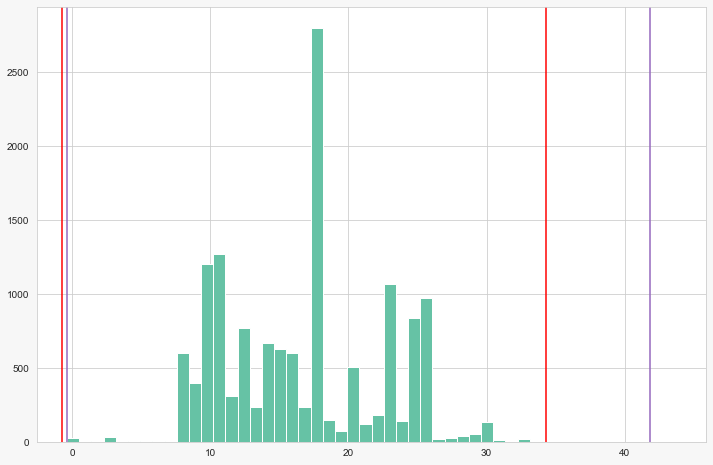

-------  column secondary_cleaner.state.floatbank5_a_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -275.0731254824576
MIN: -797.1424746400412
Границы по IQR: -525.665 ... -462.410
Границы по 3s: -597.634 ... -370.278


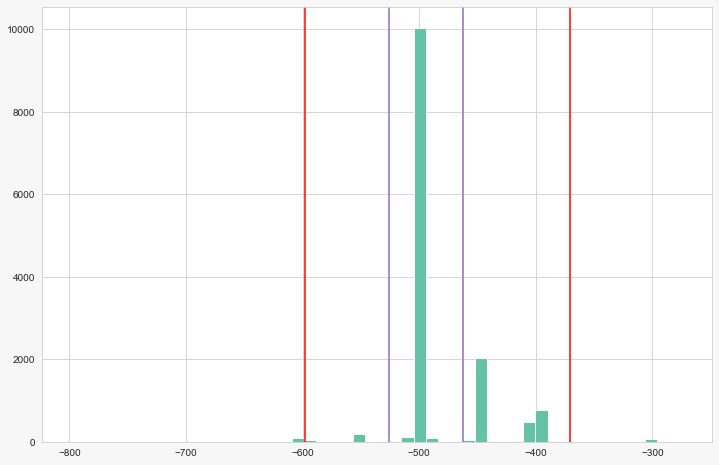

-------  column secondary_cleaner.state.floatbank5_b_air  ----------
Count NaN: 1
Count ZERO: 0
MAX: 27.926001392585444
MIN: 0.646207673589221
Границы по IQR: 0.646 ... 27.926
Границы по 3s: -4.232 ... 30.361


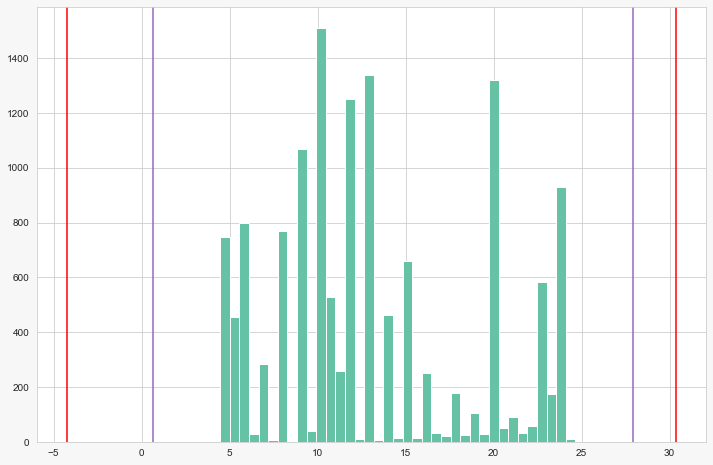

-------  column secondary_cleaner.state.floatbank5_b_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -157.39607088804976
MIN: -800.0061797584956
Границы по IQR: -593.944 ... -359.349
Границы по 3s: -601.590 ... -366.343


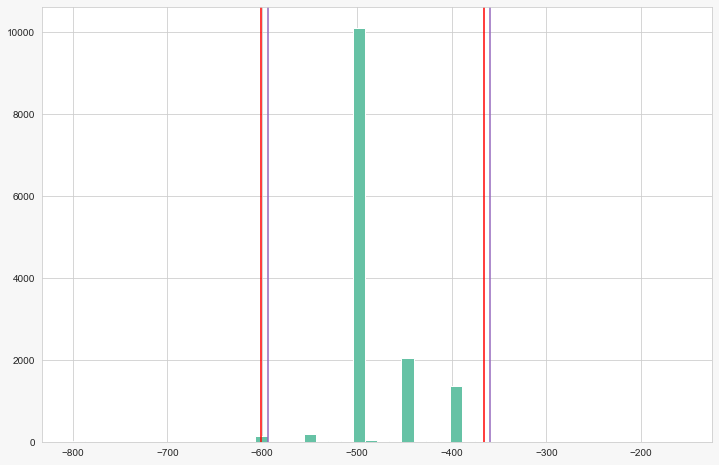

-------  column secondary_cleaner.state.floatbank6_a_air  ----------
Count NaN: 2
Count ZERO: 0
MAX: 32.1889056610072
MIN: 0.195324329874147
Границы по IQR: 0.195 ... 32.189
Границы по 3s: 2.284 ... 36.871


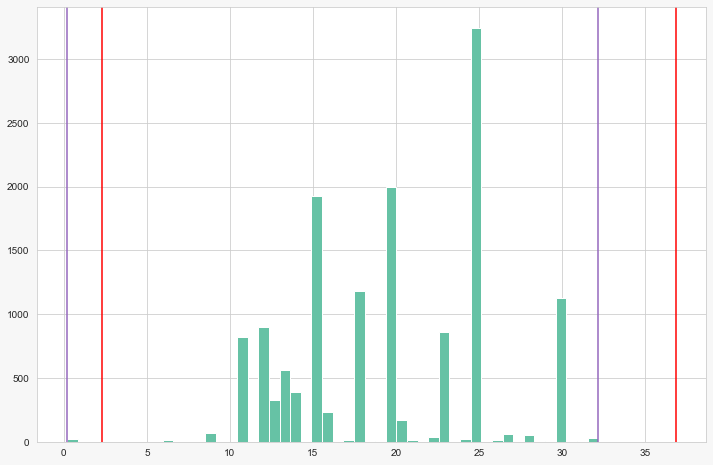

-------  column secondary_cleaner.state.floatbank6_a_level  ----------
Count NaN: 1
Count ZERO: 0
MAX: -104.42745915373588
MIN: -809.3986675137694
Границы по IQR: -503.162 ... -497.119
Границы по 3s: -618.036 ... -395.561


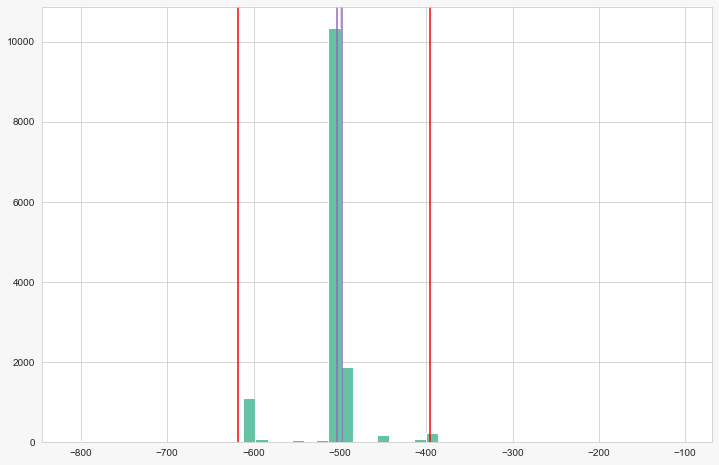

In [9]:
df = df_train

for col in df.select_dtypes(include=['number']).columns:
# for col in df.columns[df.columns.str.contains('secondary_cleaner.state.floatbank4_b_level')]:
    col_cnt_nan = df[col].isna().sum()
    col_cnt_zero = len(df[df[col]==0])
    l_bound_3s, u_bound_3s = calc_bounds_outliers(df, col, '3s', 2, 2)
    l_bound, u_bound = calc_bounds_outliers(df, col, 'iqr', 2, 2)
    print(f'-------  column {col}  ----------')
    print('Count NaN:', col_cnt_nan)
    print('Count ZERO:', col_cnt_zero)
    print('MAX:', df[col].max())
    print('MIN:', df[col].min())
    print(f'Границы по IQR: {l_bound:.3f} ... {u_bound:.3f}')
    print(f'Границы по 3s: {l_bound_3s:.3f} ... {u_bound_3s:.3f}')
    ax = df[col].hist(bins=50)
#     ax.set_yscale('log')
    ax.axvline(l_bound_3s, c="r")
    ax.axvline(u_bound_3s, c="r")
    ax.axvline(u_bound, c="#9467bd")
    ax.axvline(l_bound, c="#9467bd")
    plt.show()

Мы видим, что в данных много выбросов, есть пропуски, есть нулевые концентрации. Нужно будет предусмотреть возможность удаления выбросов у фичей. Возможно это позволит улучшить модель (а может и нет 😃)

### 1.2 Проверка расчета эффективности обогащения rougher.output.recovery

In [10]:
C = df['rougher.output.concentrate_au']
F = df['rougher.input.feed_au']
T = df['rougher.output.tail_au']

recovery_rough = C * (F-T) / (F * (C-T))*100
MAE = mean_absolute_error(recovery_rough, df['rougher.output.recovery'])
MAE


9.73512347450521e-15

#### Выводы

Колонка rougher.output.recovery полностью совпадает с рассчитанным самостоятельно значением. Отклонение 9.73512347450521e-15 можно объяснить пределом точности вычислений с плавающей точкой в питоне

### 1.3 Проанализируйте признаки, недоступные в тестовой выборке

In [11]:
list(df_train.columns.difference(df_test.columns))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

#### Вывод

Данные параметры описывают параметры процесса C (concentrate) и T (tail) после этапа rougher.
также  нет 4 колонок calculation

Эти параметры содержат информацию о ключевых признаках и их использование приведет к data leakage, поэтому они удалены из test, все правильно

### 1.4 Предобработка



Определим колонки для прогнозирования целевых признаков на этапах rougher и final

In [12]:
X_cols = {
    'rougher': [
        'rougher.input.feed_ag',
        'rougher.input.feed_pb',
        'rougher.input.feed_rate',
        'rougher.input.feed_size',
        'rougher.input.feed_sol',
        'rougher.input.feed_au',
        'rougher.input.floatbank10_sulfate',
        'rougher.input.floatbank10_xanthate',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_a_level',
        'rougher.state.floatbank10_b_air',
        'rougher.state.floatbank10_b_level',
        'rougher.state.floatbank10_c_air',
        'rougher.state.floatbank10_c_level',
        'rougher.state.floatbank10_d_air',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_air',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_f_level'
    ],
    'final': [
        'primary_cleaner.input.sulfate',
        'primary_cleaner.input.depressant',
        'primary_cleaner.input.feed_size',
        'primary_cleaner.input.xanthate',
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_b_air',
        'primary_cleaner.state.floatbank8_b_level',
        'primary_cleaner.state.floatbank8_c_air',
        'primary_cleaner.state.floatbank8_c_level',
        'primary_cleaner.state.floatbank8_d_air',
        'primary_cleaner.state.floatbank8_d_level',
        'rougher.input.feed_ag',
        'rougher.input.feed_pb',
        'rougher.input.feed_rate',
        'rougher.input.feed_size',
        'rougher.input.feed_sol',
        'rougher.input.feed_au',
        'rougher.input.floatbank10_sulfate',
        'rougher.input.floatbank10_xanthate',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_a_level',
        'rougher.state.floatbank10_b_air',
        'rougher.state.floatbank10_b_level',
        'rougher.state.floatbank10_c_air',
        'rougher.state.floatbank10_c_level',
        'rougher.state.floatbank10_d_air',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_air',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_f_level',
        'secondary_cleaner.state.floatbank2_a_air',
        'secondary_cleaner.state.floatbank2_a_level',
        'secondary_cleaner.state.floatbank2_b_air',
        'secondary_cleaner.state.floatbank2_b_level',
        'secondary_cleaner.state.floatbank3_a_air',
        'secondary_cleaner.state.floatbank3_a_level',
        'secondary_cleaner.state.floatbank3_b_air',
        'secondary_cleaner.state.floatbank3_b_level',
        'secondary_cleaner.state.floatbank4_a_air',
        'secondary_cleaner.state.floatbank4_a_level',
        'secondary_cleaner.state.floatbank4_b_air',
        'secondary_cleaner.state.floatbank4_b_level',
        'secondary_cleaner.state.floatbank5_a_air',
        'secondary_cleaner.state.floatbank5_a_level',
        'secondary_cleaner.state.floatbank5_b_air',
        'secondary_cleaner.state.floatbank5_b_level',
        'secondary_cleaner.state.floatbank6_a_air',
        'secondary_cleaner.state.floatbank6_a_level'
    ]
}
y_col = {'rougher': 'rougher.output.recovery', 'final': 'final.output.recovery'}

In [13]:
# Преобразуем колонку даты в формат даты
for df in [df_test, df_train, df_full]:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

Т.к. в test нет целевых признаков, то, чтобы было удобно оценивать точность, добавим в df_test их из df_full

In [14]:
df_test = df_test.merge(df_full[['date', y_col['rougher'], y_col['final']]], how='left', on='date')

Создадим словари X_ и y_ хранящие feautures и targets для каждого этапа (`rougher` и `final`) для train и test

In [15]:
X_ = {'train': 
      {
          'rougher': df_train[X_cols['rougher']],
          'final': df_train[X_cols['final']]
      },
      'test': 
      {
          'rougher': df_test[X_cols['rougher']], 
          'final': df_test[X_cols['final']]
      }
     }
y_ = {'train': 
      {
          'rougher': df_train[y_col['rougher']],
          'final': df_train[y_col['final']]
      },
      'test': 
      {
          'rougher': df_test[y_col['rougher']], 
          'final': df_test[y_col['final']]
      }
     }

Посмотрим сколько нулей и пропусков в фичах и таргетах на `train` и `test` для `rougher` и `final`

In [16]:
displ = []
for n,v in y_.items():
    for m,t in v.items():
        displ.append(['y', n, m, t.isin([0]).sum().sum(), t.isna().sum().sum(),  t.shape])
for n,v in X_.items():
    for m,t in v.items():
        displ.append(['X', n, m, t.isin([0]).sum().sum(), t.isna().sum().sum(),  t.shape])
pd.DataFrame(displ, columns=['source', 'sample', 'part', 'zeros', 'nan', 'shape'])

,source,sample,part,zeros,nan,shape
0,y,train,rougher,297,0,"(14149,)"
1,y,train,final,58,0,"(14149,)"
2,y,test,rougher,97,0,"(5290,)"
3,y,test,final,40,0,"(5290,)"
4,X,train,rougher,0,1273,"(14149, 22)"
5,X,train,final,22,1705,"(14149, 52)"
6,X,test,rougher,0,63,"(5290, 22)"
7,X,test,final,1,90,"(5290, 52)"


Сделаем два трансформатора:
1. для трансформации целевого признака (target) чтобы убрать нули, заменив их на соседние значения. Он может трансформироваться только при обучении, но не должен трогать тестовый фолд при CV или тестовую выборку. Поэтому используем за основу Sampler из imblearn
2. для трансформации фичей (feautures) чтобы убрать нули, пропуски, выбросы, заменив их на соседние значения или на подобные по методу KNN. А также для масштабирования фичей scaler-ом. Тут можно делать fit на train и модифицировать test фолд или test выборку

In [17]:
def transform_target(X, y):
    y = y.replace(to_replace=0, value=np.nan)
    y = y.fillna(method='ffill')
    y = y.fillna(method='bfill')
    return X, y

TargetTransformer = FunctionSampler(func=transform_target, validate=False)


In [18]:
class InputTransformer(TransformerMixin, BaseEstimator):
    """
    Provide primary data transformation

    Parameters
    ----------
    zero_to_nan: bool, optional
    is_set_outliers_as_nan: bool, optional
    knn:         bool, optional
    ffill:       bool, optional
    interpolate: bool, optionale

    Notes
    -----
    Must be used in a Pipeline object and must be the first step. fit
    and predict should be called with a pandas.DataFrame object
    """
    
    def __init__(self, 
                 zero_to_nan= True, 
                 is_set_outliers_as_nan=False, 
                 knn=True, 
                 ffill=False, 
                 interpolate=False
                ):
        # no logic allowed here, just assign attributes
        # from __init__ args
        self.zero_to_nan = zero_to_nan
        self.is_set_outliers_as_nan = is_set_outliers_as_nan
        self.knn = knn
        self.ffill = ffill
        self.interpolate = interpolate
    
    
    def fit(self, X, y=None):
        
        # we need this to pass check_estimator
        #X_out, y = check_X_y(X, y)
        #X = X if hasattr(X, 'columns') else X_out

        # our estimator is designed to work on structures
        # that have a columns attribute (such as pandas Data Frame)
        if hasattr(X, 'columns'):
            bounds = {}
            for col in X.columns:
                lbound, ubound = calc_bounds_outliers(X, col, mode='3s')
                bounds[col] = (lbound, ubound)
            
            self.bounds = bounds
            
            if self.knn:
                self.scaler = StandardScaler().fit(X)
                self.imputer = KNNImputer(n_neighbors=4, weights='distance').fit(self.scaler.transform(X))
        
        else:
            warnings.warn('Input does not have a columns attribute')
        return self
    
    def transform(self, X):
        # these two are to pass check_estimator
#         check_is_fitted(self)
#         X_out = check_array(X)
#         X = X if hasattr(X, 'columns') else X_out
        
        if self.is_set_outliers_as_nan:
            for col in X.columns:
                X.loc[(X[col] >= self.bounds[col][0]) & (self.bounds[col][1] <= X[col])] = np.nan
        #  Заменяем нули на пропуски
        if self.zero_to_nan:
#             X = X.replace(to_replace=0, value=np.nan)
            for col in X.columns:
                X.loc[abs(X[col]) < 0.0000001] = np.nan
        
        if self.knn:
            tmp_x = self.scaler.transform(X)
            tmp_x = self.imputer.transform(tmp_x)
            tmp_x = self.scaler.inverse_transform(tmp_x)
            X = pd.DataFrame(data = tmp_x, columns=X.columns)
        elif self.ffill:
            X = X.fillna(method='ffill')
            X = X.fillna(method='bfill')
        elif self.interpolate:
            X = X.interpolate(limit_direction='both')
        
        
        return X

Посмотрим как расположены относительно друг друга части train  и test

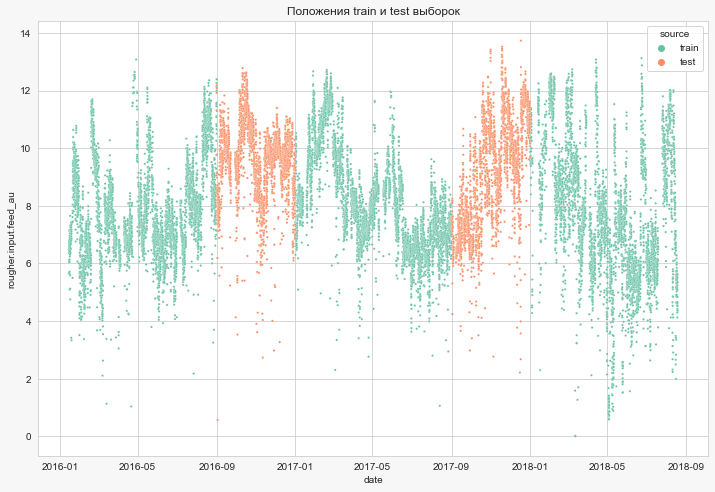

In [19]:
df_train['source'] = 'train'
df_test['source'] = 'test'

t = pd.concat([df_train[['date','rougher.input.feed_au','source']], df_test[['date','rougher.input.feed_au', 'source']]], ignore_index=True)

ax = sns.scatterplot(data=t, x='date', y='rougher.input.feed_au', hue='source', s=5)
ax.set_title('Положения train и test выборок')
plt.show()

#### Вывод

В Мы подготовили трансформаторы для обраоботки выбросов, нулей, пропусков и замены их на схожие значения.

## Анализ данных

### 2.1 Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

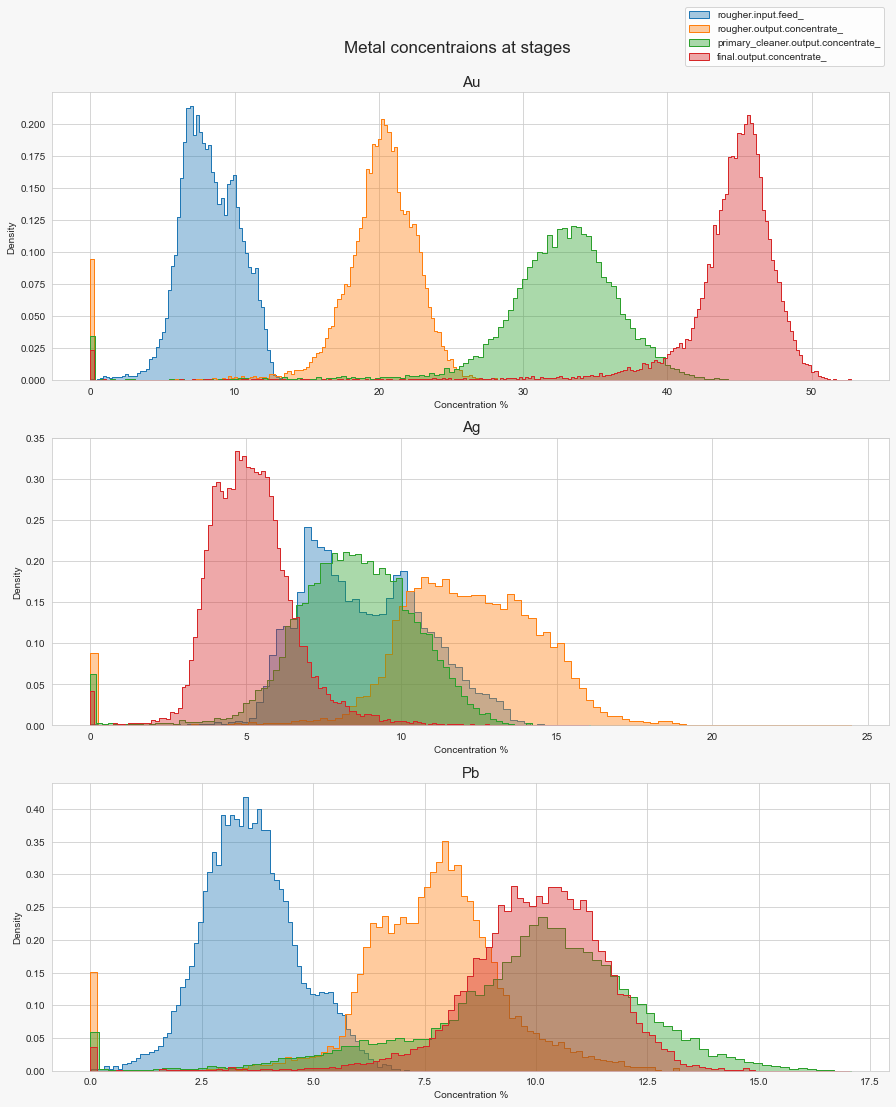

In [20]:
df=df_full
steps = [
    'rougher.input.feed_',
    'rougher.output.concentrate_',
    'primary_cleaner.output.concentrate_',
    'final.output.concentrate_',
]
metals = ['Au', 'Ag', 'Pb']

fig = plt.figure(figsize=(15,18))
    
i = 0
for metal in metals:
    i += 1
    ax = plt.subplot(3,1, i)
    s = 0
    for step in steps:
        
        sns.histplot( data=df[step + metal.lower()]
                        , alpha=0.4
                        , element='step'
                        , stat='density'
                        , ax = ax
                        , legend=False
                        , color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][s]

        );
        s += 1
    ax.set(xlabel="Concentration %", ylabel="Density")
    ax.set_title(metal, fontsize=15)
    
fig.suptitle("Metal concentraions at stages", fontsize=17, y=0.92)
fig.legend(steps, loc='upper right', bbox_to_anchor=(0.9, 0.95))
    

#### Выводы
Убедились, что от этапа к этапу концентрация золота в руде увеличивается, начиная с 7% и заканчивая 45%.
Концентрация серебра наоборот, сократилась. А вот концентрация свинца выросла, но остается не особо высокой (около 10%)

Видны аномальные нули. Для борьбы с ними заготовлены трансформаторы

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках

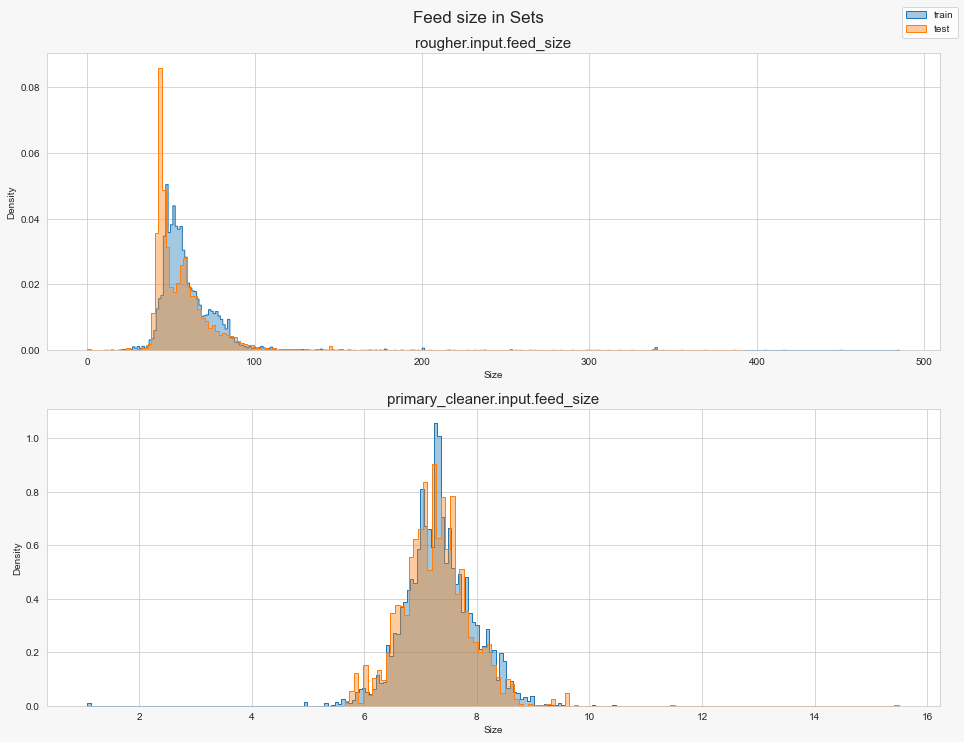

In [21]:
colnames = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

    
fig = plt.figure(figsize=(16,6*len(colnames)))
   
i = 0
for col in colnames:
    i += 1
    ax = plt.subplot(2, 1, i)
    s=0
    for df in df_train, df_test:
        s += 1

        sns.histplot( data=df[col]
                    , alpha=0.4
                    , element='step'
                    , stat='density'
                    , ax = ax
                    , legend=False
                    , color = ['#1f77b4', '#ff7f0e'][s-1]

        );

    ax.set(xlabel="Size", ylabel="Density")
    ax.set_title(col, fontsize=15)
    
fig.suptitle("Feed size in Sets", fontsize=17, y=0.93)
fig.legend(['train', 'test'], loc='upper right', bbox_to_anchor=(0.92, 0.94))

#### Выводы

Входные размеры для train и test имеют одинаковое распределение в руде, что позволяет оставить гипотезу о схожих характеристиках train и set, т.е. допустимо модель строить на train и проверять на test

Протестируем гипотезу о равенстве средних `rougher.input.feed_size` в train и test, а также гипотезу о равенстве средних `primary_cleaner.input.feed_size` в train и test

In [22]:
from scipy import stats as st

In [23]:
for colname in ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']:
    print('\n\nИсследуем гипотезу о равенстве средних у распределений\n----   ', colname,'   ----')
    results = st.ttest_ind(
        df_train[colname].dropna(), 
        df_test[colname].dropna(), 
        equal_var = False
    )

    alpha = 0.05
    print('p-значение: ', results.pvalue)
    if alpha > results.pvalue:
        print('Гипотеза H0 равенства средних отвергается. Принимаем гипотезу H1 о отличии средних')
    else:
        print('Гипотеза H0 равенства средних не может быть отвергнута.')



Исследуем гипотезу о равенстве средних у распределений
----    rougher.input.feed_size    ----
p-значение:  1.5360283753498916e-37
Гипотеза H0 равенства средних отвергается. Принимаем гипотезу H1 о отличии средних


Исследуем гипотезу о равенстве средних у распределений
----    primary_cleaner.input.feed_size    ----
p-значение:  1.3721938409942596e-08
Гипотеза H0 равенства средних отвергается. Принимаем гипотезу H1 о отличии средних


### 2.3 Исследуйте суммарную концентрацию всех веществ на разных стадиях

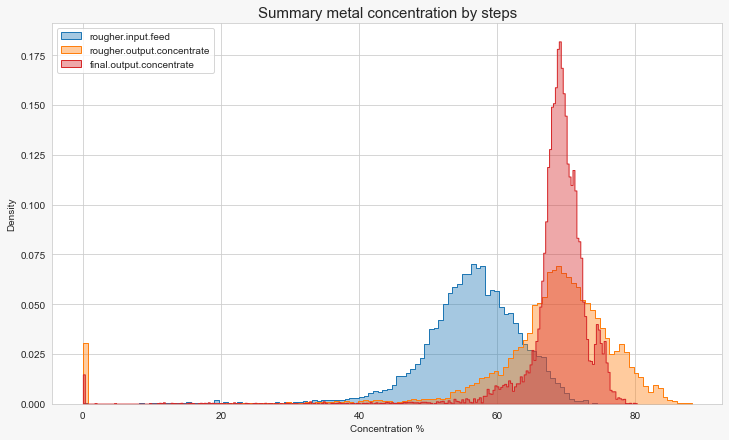

In [24]:
df = df_train
steps = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'final.output.concentrate',
]
metals = ['_au', '_ag', '_pb', '_sol']

fig = plt.figure(figsize=(12,7))
    

ax = plt.subplot(1,1, 1)
s = 0
for step in steps:

    sns.histplot( data=df.loc[:,[step + x for x in metals]].sum(axis=1)
                    , alpha=0.4
                    , element='step'
                    , stat='density'
                    , ax = ax
                    , legend=False
                    , color = ['#1f77b4', '#ff7f0e', '#d62728'][s]
    );
    s += 1
ax.set(xlabel="Concentration %", ylabel="Density")
ax.set_title('Summary metal concentration by steps', fontsize=15)
ax.legend(steps, loc='upper left')



Видны аномальные нули. Для борьбы с ними заготовлены трансформаторы

## Модель

$$\mathit{sMAPE} = \frac{1}{N} \sum\limits _{i = 1} ^{N} \frac{\left| y_i - \hat{y}_i \right|}{\left( \left| y_i \right| + \left|\hat{y}_i \right| \right) / 2} \times 100\%$$

$$\mathit{resulting\ sMAPE} = 25\% \times \mathit{sMAPE}\left( \mathit{rougher} \right) + 75\% \times \mathit{sMAPE} \left( \mathit{final} \right)$$

In [25]:
def sMAPE(t, p):
    return np.mean(abs(t - p)/(abs(t)+abs(p))) * 2

def resulting_smape(true_rougher, pred_rougher, true_final, pred_final):
    return 0.25 * sMAPE(true_rougher, pred_rougher) + 0.75 * sMAPE(true_final, pred_final)

smape_scorer = make_scorer(sMAPE,greater_is_better=False)

# Проверка: должно быть 0.2071262071262071
sMAPE(pd.Series([1, 2, 3]), pd.Series([1.2, 1.5, 3.5]))

0.2071262071262071

In [26]:
def custom_estimator(transformers, estimator):
    ppline_arr=[]
    ppline_arr.append(('TT',TargetTransformer))
    ppline_arr.append(('IT',InputTransformer()))
    
    if estimator == 'DUMMY':
        estm = DummyRegressor()
    elif estimator == 'LinR':
        estm = LinearRegression(n_jobs=-1)
    elif estimator == 'GBR':
        estm = GradientBoostingRegressor(random_state=RANDOM_STATE)
    elif estimator == 'RFR':
        estm = RandomForestRegressor(random_state=RANDOM_STATE)
    elif estimator == 'HR':
        estm = HuberRegressor()
    elif estimator == 'PAR':
        estm = PassiveAggressiveRegressor(random_state=RANDOM_STATE)
    elif estimator == 'BAG':
        estm = BaggingRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif estimator == 'HIST':
        estm = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ADA':
        estm = AdaBoostRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ARD':
        estm = ARDRegression()
    elif estimator == 'BR':
        estm = BayesianRidge()
    elif estimator == 'SGD':
        estm = SGDRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ELASTIC':
        estm = ElasticNet(random_state=RANDOM_STATE)
    
    
    for transformer in transformers:
        if transformer == 'RUS':
            trns = RandomUnderSampler(random_state=RANDOM_STATE)
        elif transformer == 'ENN':
            trns = EditedNearestNeighbours(n_jobs=-1)
        elif transformer == 'AllKNN':
            trns = AllKNN(n_jobs=-1)
        elif transformer == 'TL':
            trns = TomekLinks(n_jobs=-1)
        elif transformer == 'SMOTE':
            trns = SMOTE(random_state=RANDOM_STATE)
        elif transformer == 'ADASYN':
            trns = ADASYN(random_state=RANDOM_STATE)
        elif transformer == 'ROS':
            trns = RandomOverSampler(random_state=RANDOM_STATE)
        elif transformer == 'RS':
            trns = RobustScaler()
        elif transformer == 'SS':
            trns = StandardScaler()
        
        if transformer != 'NONE':
            ppline_arr.append((transformer,trns))
    
    ppline_arr.append(('estimator',estm))

    return Pipeline(ppline_arr)



Запускаем оптимизацию гиперпараметров.

Сейчас я заблокировал запуск, чтобы пересчет книги был побыстрее, но можно запустить при желании. Времени нужно 25 минут на локальном ПК, на JupyterHub около 2 часов.

In [27]:
%%time

def objective(trial):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    
    
    pipeline = custom_estimator(transformers=transformers, estimator=estimator)
    params = {}
    
    # нулевую итерацию делаем с дефолтными параметрами
    if trial.number > 0:
        if estimator in ['RFR', 'GBR']:
            params = {
                 'estimator__criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error', 'mse', 'mae'])
                 , 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=200, step=1, log=True)
                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=30, step=1, log=False)
                 , 'estimator__min_samples_leaf': trial.suggest_int(name='min_samples_leaf', low=1, high=30, step=1, log=False)
            }
            if estimator == 'GBR':
                params['estimator__loss'] = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])
                params['estimator__learning_rate'] = trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                params['estimator__subsample'] = 0.5  #trial.suggest_float(name='subsample', low=0.3, high=0.99, step=0.01, log=False)
        elif estimator == 'DUMMY':
            params = {
                 'estimator__strategy': trial.suggest_categorical('strategy', ['mean', 'median'])
            }
        elif estimator == 'BAG':
            params = {
                 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=50, step=1, log=True)
                , 'estimator__max_samples': trial.suggest_int(name='max_samples', low=1, high=5, step=1, log=False)
                , 'estimator__max_features': trial.suggest_int(name='max_features', low=1, high=7, step=1, log=False)
            }
        elif estimator == 'HIST':
            params = {
                 'estimator__loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'poisson'])
                , 'estimator__learning_rate': trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                , 'estimator__max_leaf_nodes': trial.suggest_int(name='max_leaf_nodes', low=31, high=101, step=1, log=False)
#                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=100, step=1, log=True)
            }
        elif estimator == 'ADA':
            params = {
                 'estimator__loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])
                , 'estimator__learning_rate': trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                , 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=50, step=1, log=True)
#                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=100, step=1, log=True)
            }
        elif estimator == 'ELASTIC':
            
            params = {
                 'estimator__l1_ratio': trial.suggest_float(name='l1_ratio', low=0.001, high=0.999, step=0.001, log=False)
            }
                 
    
    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    kf = KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X, y=y, 
                            scoring=smape_scorer, cv=kf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   score.mean()
# ======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<
if False: # сделал FALSE чтобы не ждать каждый раз 2 часа на пересчет. При необходимости можно запустить. Код работает.
# ======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<
    for  step in ['rougher', 'final']:
        print('\n\n\n----------------------------------\n---------  ',
              step,
              ' -------------\n----------------------------------')

        X = X_['train'][step]
        y = y_['train'][step]

        best_score_ = -10000
        log_history = {}
#         ['DUMMY', 'LinR', 'PAR', 'BAG', 'HIST', 'ADA', 'ARD', 'BR', 'SGD', 'ELASTIC']
        for est in ['DUMMY', 'LinR',  'HIST', 'ADA', 'ELASTIC']:
            t1 = time.time()
            sampler = optuna.samplers.TPESampler(seed=10)
            if est in ['RFR', 'GBR','BAG', 'HIST', 'ADA', 'ELASTIC']:
                n_attempts = 100
            elif est == 'DUMMY':
                n_attempts = 5
            else:
                n_attempts = 1

            transformers=['SS']
            estimator=est

            study = optuna.create_study(sampler=sampler, direction="maximize")
            study.optimize(objective, n_trials=n_attempts, timeout=60*60, n_jobs=-1)

            if best_score_ <= study.best_trial.values[0]:
                best_params_ = study.best_trial.params
                best_estimator_ = estimator
                best_score_ = study.best_trial.values[0]
            log_history.update({estimator:{
                'score': study.best_trial.values[0],
                'params': study.best_trial.params,
                'time': time.time() - t1
            }})
        print(log_history)
        print ('BEST is', best_estimator_, 'score=', best_score_ , 'params=',  best_params_)                        



Wall time: 0 ns


Выше код находит оптимальные параметры алгоритмов регрессии, далее мы считаем скоры на всем train

Модели GradientBoostingRegressor и RandomForestRegressor чрезвычайно долго считались, поэтому их я убрал из рассмотрения. При необходимости и наличии времени, можно добавить в список моделей и посчитать и эти тоже, но там не менее 3 часов для GradientBoostingRegressor.

In [28]:
%%time
array_best_={
    'rougher': {
        'DUMMY': {'score': -0.1134981196168162, 'params': {'strategy': 'median'}, 'time': 9.521639823913574}, 
        'LinR': {'score': -0.09196550354528232, 'params': {}, 'time': 1.9624583721160889}, 
        'HIST': {'score': -0.07137003129479653, 'params': {'loss': 'absolute_error', 'learning_rate': 0.15000000000000002, 'max_leaf_nodes': 97}, 'time': 546.3823568820953}, 
        'ADA': {'score': -0.09106882372698571, 'params': {'loss': 'exponential', 'learning_rate': 0.14, 'n_estimators': 16}, 'time': 349.4018621444702}, 
        'ELASTIC': {'score': -0.0967209053343506, 'params': {'l1_ratio':0}, 'time': 2.1975901126861572}
    },
    'final':{
        'DUMMY': {'score': -0.11040969616799459, 'params': {'strategy': 'median'}, 'time': 41.88937735557556}, 
        'LinR': {'score': -0.089636658686651, 'params': {}, 'time': 8.984272480010986}, 
        'HIST': {'score': -0.06756940890004166, 'params': {'loss': 'squared_error', 'learning_rate': 0.12000000000000001, 'max_leaf_nodes': 101}, 'time': 1134.1258718967438}, 'ADA': {'score': -0.08950032512699982, 'params': {'loss': 'exponential', 'learning_rate': 0.13, 'n_estimators': 33}, 'time': 1374.788616657257}, 
        'ELASTIC': {'score': -0.0942708248318951, 'params': {'l1_ratio':0}, 'time': 9.381423950195312}
    }
}

for est in ['DUMMY', 'LinR', 'HIST', 'ADA', 'ELASTIC']:
    
    kf = KFold(n_splits=4, shuffle=False
#                , random_state=RANDOM_STATE
              )

    t1 = time.time()
    estimator = est
    pipeline = custom_estimator(transformers=['SS'], estimator=est)
    
    res = []
    for  step in ['rougher', 'final']:
        X = X_['train'][step]
        y = y_['train'][step]
        params = array_best_[step][est]['params']
        params = {'estimator__'+name: v for name, v in params.items()}
        pipeline.set_params(**params)

        pipeline.fit(X, y)
        # проводим кросс-валидацию  
        score = cross_val_score(estimator=pipeline, X=X, y=y, 
                                scoring=smape_scorer, 
                                cv=kf, n_jobs=-1)
        res.append(score.mean())
    res_score = (np.array(res)*np.array([0.25, 0.75])).sum()
    print('estimator', est, 'res_score', -res_score, 'time', time.time() - t1, 'res', res)

estimator DUMMY res_score 0.11680084328621451 time 17.320942401885986 res [-0.12268916542145406, -0.11483806924113467]
estimator LinR res_score 0.11654968921219924 time 16.50008225440979 res [-0.10877784488111751, -0.11914030398922648]
estimator HIST res_score 0.11260511190534823 time 30.376413583755493 res [-0.11302655040666133, -0.11246463240491054]
estimator ADA res_score 0.10908999005342038 time 33.7723114490509 res [-0.11769872450592794, -0.10622041190258452]


C:\Users\INKERMAN\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.149e+05, tolerance: 9.066e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\INKERMAN\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.877e+05, tolerance: 1.258e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

estimator ELASTIC res_score 0.10453604721858954 time 21.18809962272644 res [-0.10960577895776186, -0.10284613663886544]
Wall time: 1min 59s


In [29]:
pipeline = custom_estimator(transformers=['SS'], estimator='LinR')
pipeline.fit(X_['train']['rougher'],y_['train']['rougher'])
sMAPE(pipeline.predict(X_['test']['rougher']), y_['test']['rougher'])

0.08135465300175083

Лучшей на train выглядит модель ELASTIC (ElasticNet) для предсказания обоих целевых признаков. Она значительно опережает DUMMY (10.4% против 11.7%). Выбираем ее для test.
Но ради интереса прогоним на test и все остальные модели.

**Важно:** гипер-параметры модели для `rougher` и `final` могут быть разные, но в нашем случае почти совпали


In [30]:
%%time

for est in ['DUMMY',  'LinR', 'HIST', 'ADA', 'ELASTIC']:
    t1 = time.time()
    estimator = est
    pipeline = custom_estimator(transformers=['SS'], estimator=estimator)

    y_pred = {}
    y_act = {}
#     N = 20000
    for  step in ['rougher', 'final']:
        X_train = X_['train'][step]
        y_train = y_['train'][step]
        X_test = X_['test'][step]
        
        params = array_best_[step][est]['params']
        params = {'estimator__'+name: v for name, v in params.items()}
        pipeline.set_params(**params)

        y_act[step] = y_['test'][step]

        pipeline.fit(X_train, y_train)
        y_pred[step] = pipeline.predict(X_test)

    res = resulting_smape(y_act['rougher'], y_pred['rougher'], y_act['final'], y_pred['final'])
    print('estimator', est, 'res', res, 'time', time.time() - t1)

estimator DUMMY res 0.09444907472786843 time 9.2562096118927
estimator LinR res 0.09488823253348745 time 7.944261789321899
estimator HIST res 0.093915311470419 time 15.168092012405396
estimator ADA res 0.08913257734657211 time 17.095552682876587


C:\Users\INKERMAN\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.149e+05, tolerance: 9.066e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\INKERMAN\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.877e+05, tolerance: 1.258e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

estimator ELASTIC res 0.08685096237508233 time 10.268654108047485
Wall time: 59.7 s


Видим, что на test модель ELASTIC показала sMAPE 8.7%

Мы не должны были сравнивать но интересно заметить, что лучшая модель ELASTIC по прежнему лучшая, но уже только немного лучше DUMMY (8.7% против 9.4%)



## Итоговый Вывод

В ходе проекты была создана оптимальная модель с целью прогнозирования коэффициента эффективности обогащения. При этом метрикой служила симметричная MAPE<br>
При знакомстве с данными были выявлены проблемы с пропусками и с сомнительными данными. Данные проблемы были разрешены заменой на соседние значения (согласно постановке задачи "Соседние по времени параметры часто похожи")<br>
При построении модели было нужно прогнозировать два целевых признака 'rougher.output.recovery', 'final.output.recovery'. Для каждого прогноза формировался свой список feautures и формировалась модель. на основании тех параметров, которые были согласно производственного цифла доступны к моменту прогнозирования выбранного признака.<br>
<br>
Были протестированы модели 
- LinearRegression,
- HistGradientBoostingRegressor,
- AdaBoostRegressor,
- ElasticNet

Предварительно модели проходили нормализацию с использованием StandartScaler, замена пропусков и нулей в фичах на соседние по времени методом KNN. Также оказалось эффективным на обучающей выборке заменить нули в target на соседние значения<br>
Процесс подбора гиперпараметров производился пакетом OPTUNA с кросс-валидацией. Процесс проводился отдельно для 'rougher' и 'final'<br>
Оптимальной моделью оказалась ElasticNet, показавшая на обучающей выборке показатель итоговой sMAPE 10.4%, что ниже DUMMY(median) с показателем 11.7%<br>
<br>
На тестовой выборке модель показала метрику итоговой sMAPE 8.7%


## Рекомендации

Обратить внимание на выбросы и нули в данных. Их влияние на качество модели чрезвычайно велико. Если разобраться с мусорными данными это позволит существенно улучшить модель. Ошибку можно довести до 5% и ниже если отсечь выбросы.

